# Cluster FCI examples

This notebook gives some examples on the C-FCI algorithm and how it compares to the FCI algorithm on different handcrafted graphs. 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

import logging
logging.getLogger('rpy2').setLevel(logging.WARNING)

%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import causallearn
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.FCI import fci
from clustercausal.algorithms.FCITiers import fci_tiers
import random
from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.experiments.Evaluator import Evaluator
from clustercausal.utils.Utils import *

c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


Keep the names of the nodes in the clusters in  the same order as they are being generated for the data, otherwise the algorithm will confuse the data column ordering and node ordering. 

ClusterFCI doesn't support custom node names yet. If looking at the verbose output of FCI and C-FCI, remember that 'X1' corresponds to node '0', 'X2' to node '1', etc. . This is due to numpy array indexing. 

In [ ]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
#                          cluster_edges = [('C1', 'C2'), ('C2', 'C3')], \
#                          cluster_bidirected_edges=[('C2', 'C3')])
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6'], 'C4' : ['X7', 'X8']}, \
                         cluster_edges = [('C1', 'C2'), ('C2', 'C3'), ('C1', 'C4')], \
                         cluster_bidirected_edges=[('C2', 'C3'), ('C3', 'C4')])

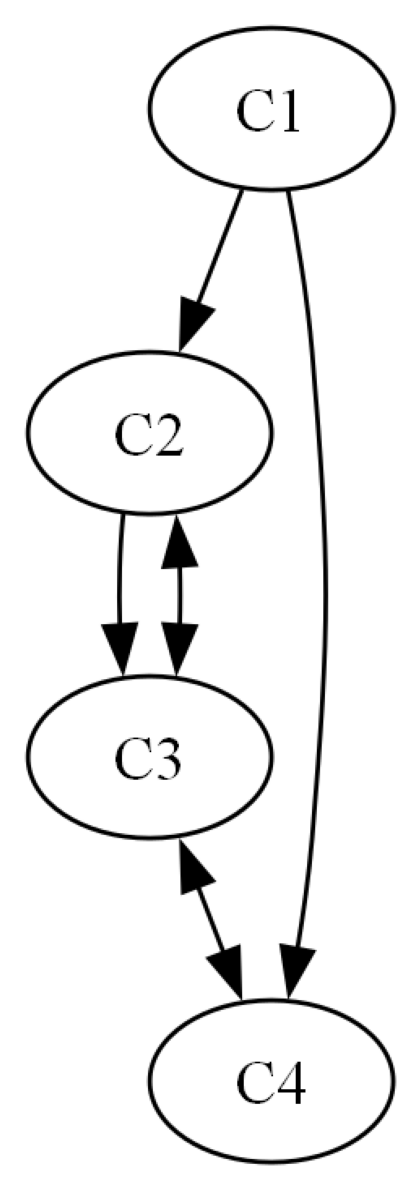

In [3]:
cluster_dag.cluster_graph.draw_pydot_graph()

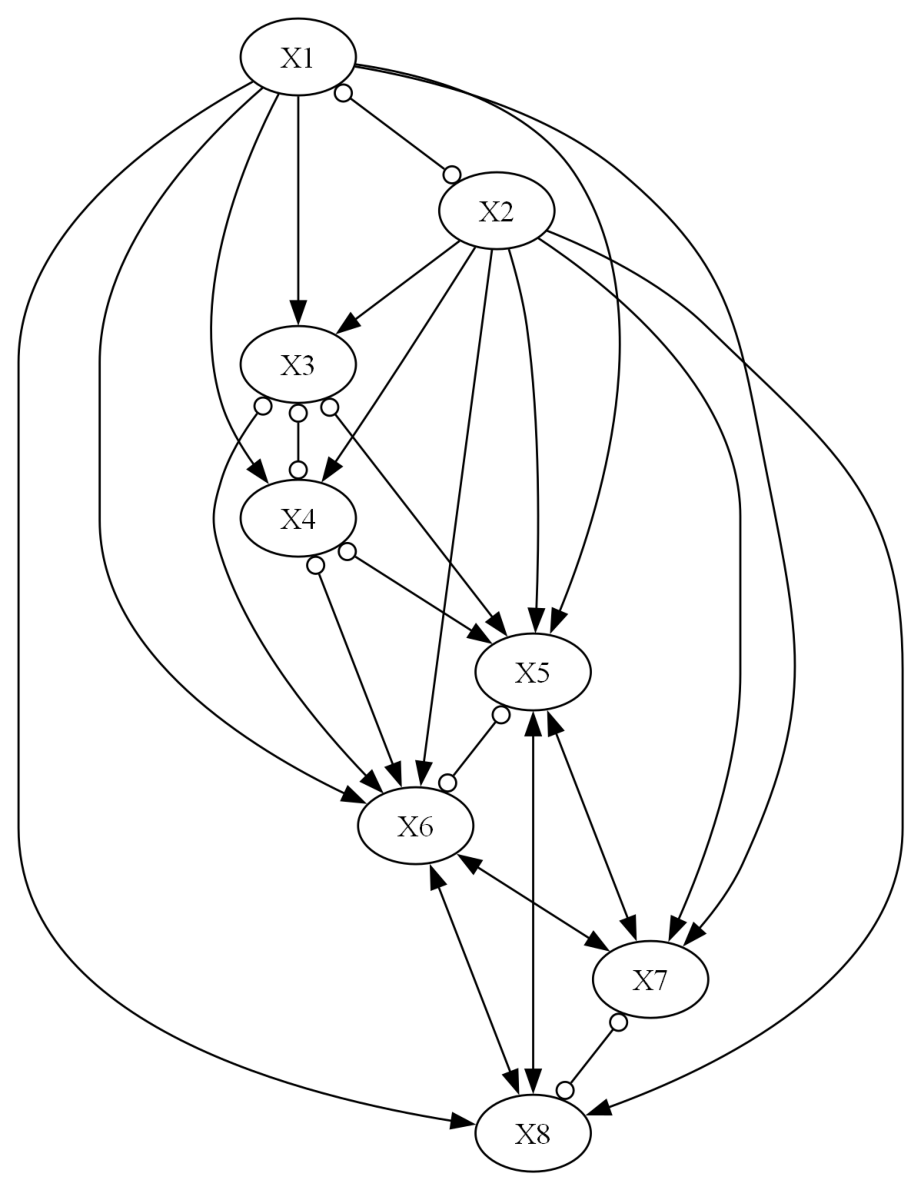

In [4]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [5]:
cluster_dag.get_cluster_topological_ordering()

['C1', 'C2', 'C4', 'C3']

### 3 node FCI

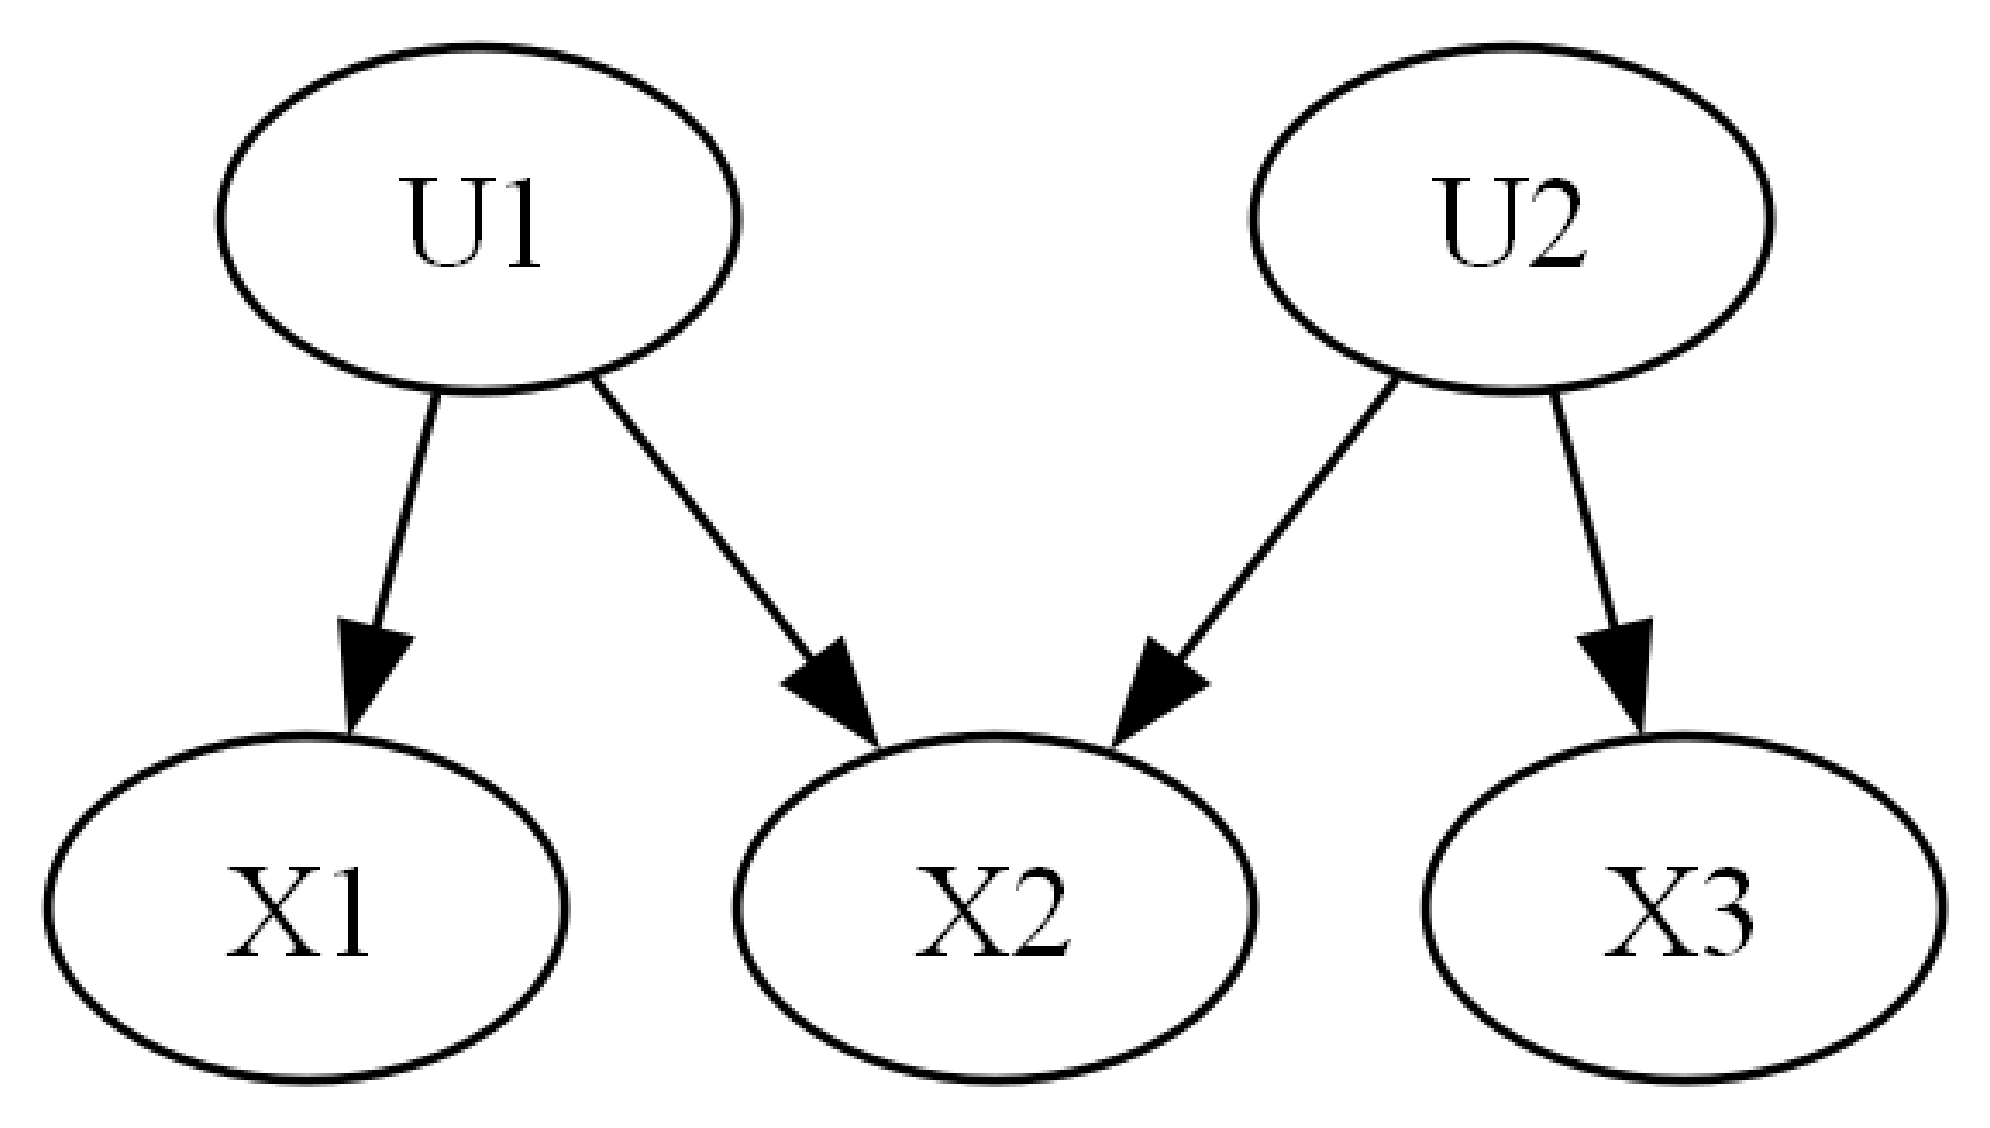

In [6]:
# List of node names
node_names = ["X1", "X2", "X3", "U1", "U2"]

# Parent dictionary
# parent_dict must be in topological ordering
parent_dict = {
    "X1": ["U1"],               # X1 has no parents
    "X2": ["U1", "U2"],           # X2 has X1 as a parent
    "X3": ["U2"],
    "U1": [],
    "U2": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [7]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([ 2.01974401,  1.15061218,  0.41353516,  1.52302986, -0.23415337])

In [8]:
# remove confounders from X
X = X[:,:3]
X

array([[ 2.01974401,  1.15061218,  0.41353516],
       [-0.70361134,  1.65229847,  1.30999477],
       [-2.37669794, -4.10392783, -1.48295556],
       ...,
       [ 2.29221043,  3.13377535,  0.55856252],
       [ 1.70750982, -1.71298002, -2.82726854],
       [ 0.32201439,  1.75610359,  2.01589587]])

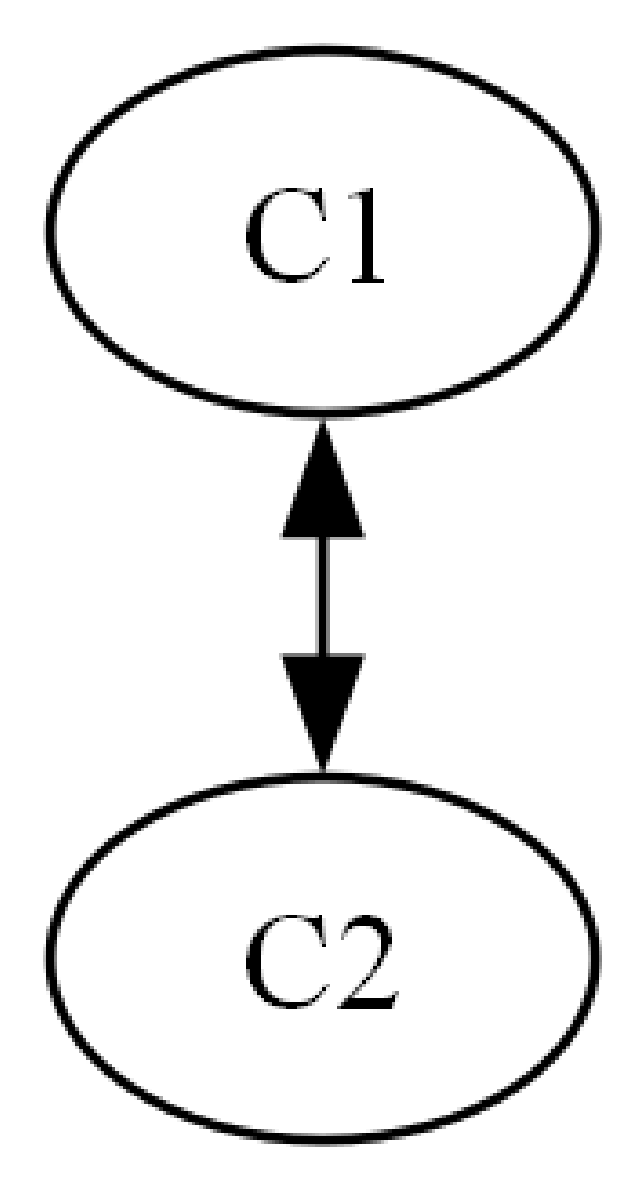

In [9]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3']}, cluster_edges = [])
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' :['X3']}, cluster_edges = [], cluster_bidirected_edges=[('C1', 'C2')])
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X3'], 'C2' :['X2']}, cluster_edges = [], cluster_bidirected_edges=[('C1', 'C2')])
cluster_dag.cluster_graph.draw_pydot_graph()

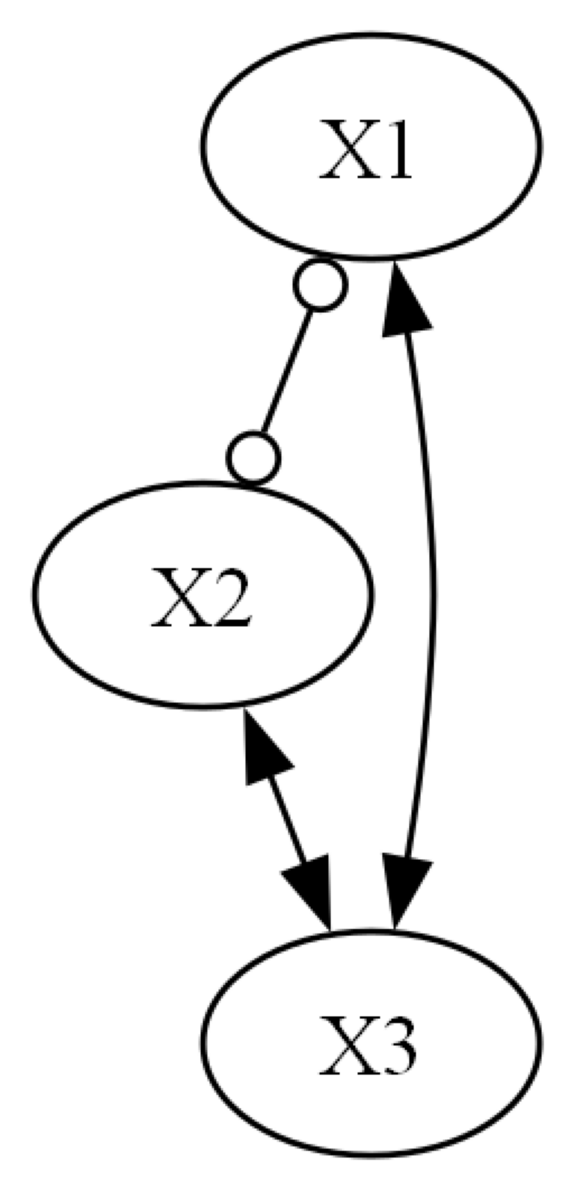

In [10]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [11]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [12]:
cluster_cg, cluster_edges = cluster_fci.run()

C2 phase, Depth=0, working on node 2: 100%|██████████| 1/1 [00:00<?, ?it/s, duration: 0.00sec]


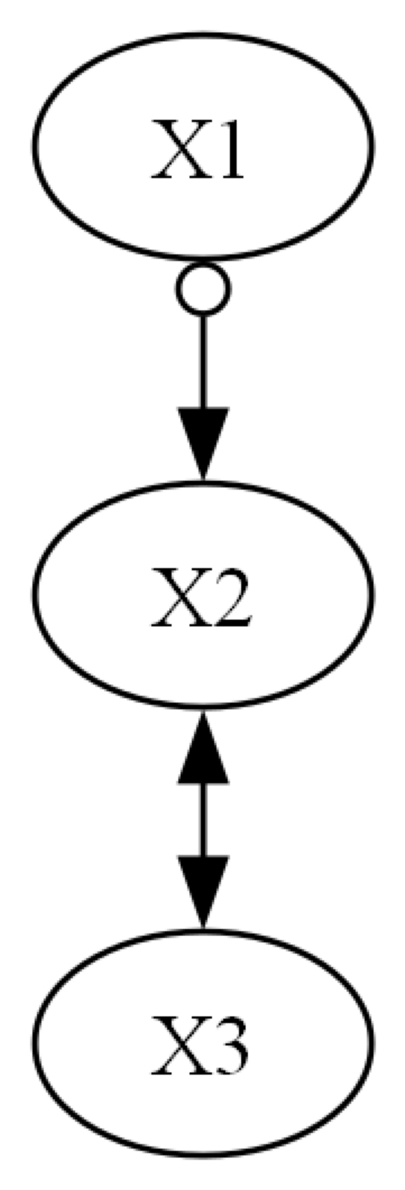

In [13]:
cluster_cg.draw_pydot_graph()

In [14]:
tiers = cluster_dag.get_cluster_topological_ordering()
cluster_mapping = cluster_dag.cluster_mapping
fci_tiers_cg, fci_tiers_edges = fci_tiers(tiers = tiers, \
                                          cluster_mapping = cluster_mapping, \
                                            dataset = X, alpha = 0.05, \
                                                verbose = False)

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 191.66it/s]


In [15]:
tiers = ['C1']
cluster_mapping = {'C1' : ['X1', 'X2', 'X3']}
fci_tiers_cg, fci_tiers_edges = fci_tiers(tiers = tiers, \
                                          cluster_mapping = cluster_mapping, \
                                            dataset = X, alpha = 0.05, \
                                                verbose = False)

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<?, ?it/s]         


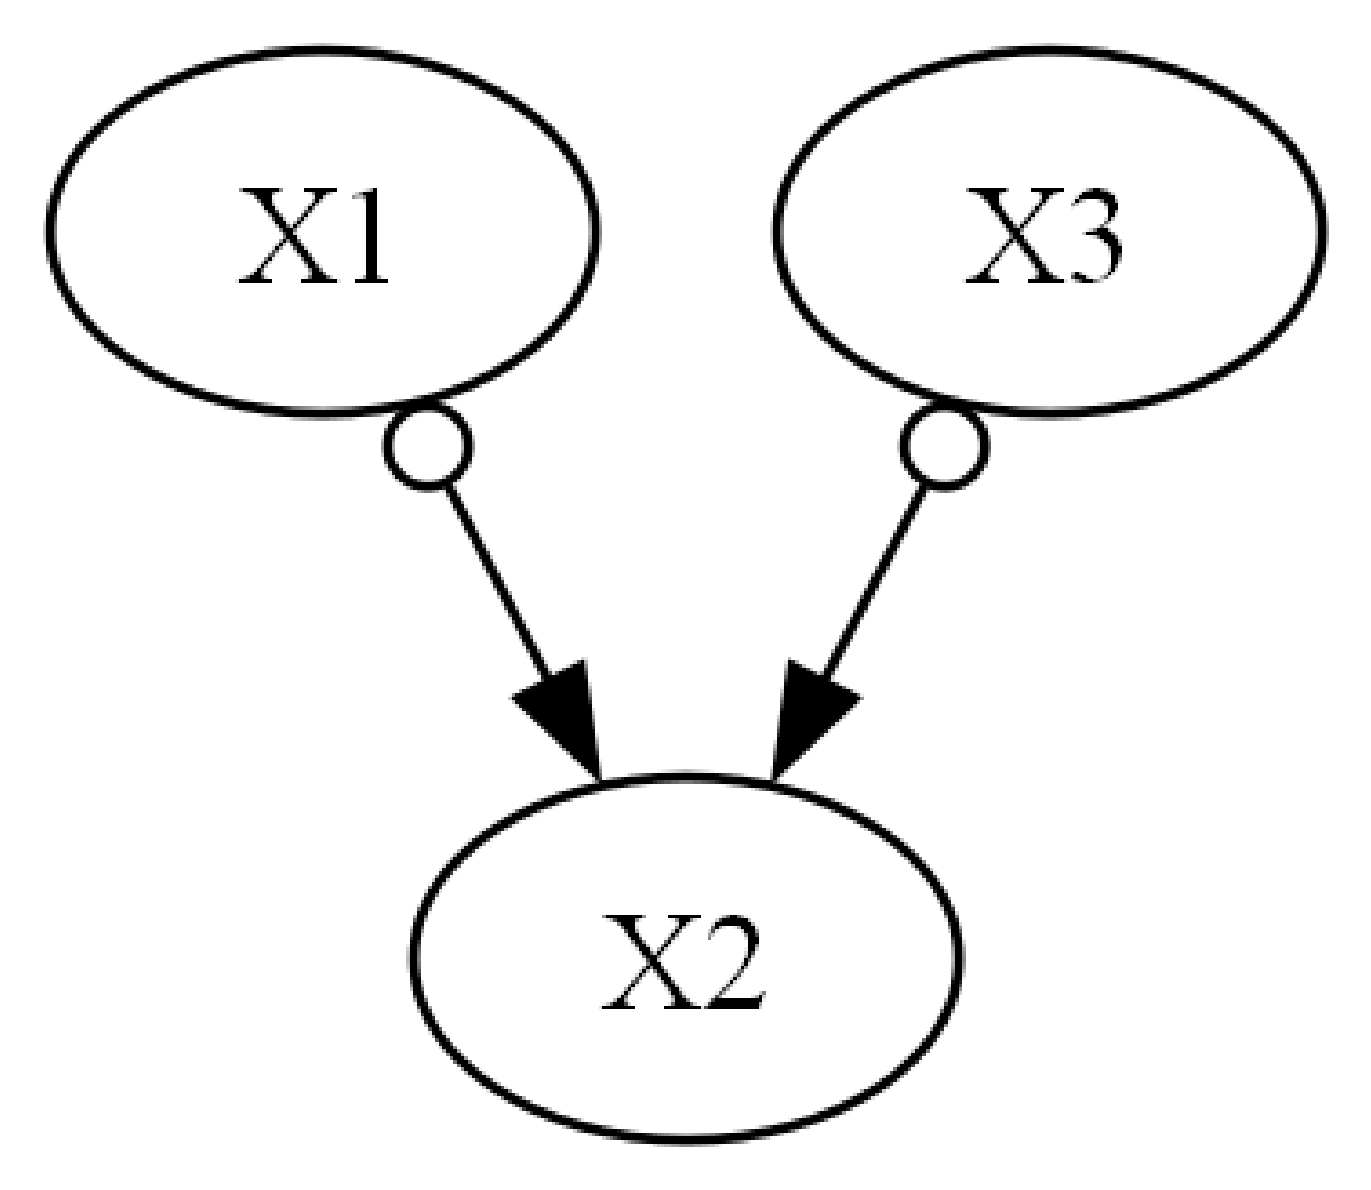

In [16]:
fci_tiers_cg.draw_pydot_graph()

In [17]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = True)
base_cg = CausalGraph(3, )
node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 ind 2 | () with p-value 0.632818

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000000

2 ind 0 | () with p-value 0.632818

2 dep 1 | () with p-value 0.000000

1 dep 0 | (2,) with p-value 0.000000

1 dep 2 | (0,) with p-value 0.000000

Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X1 *-> X2 <-* X3


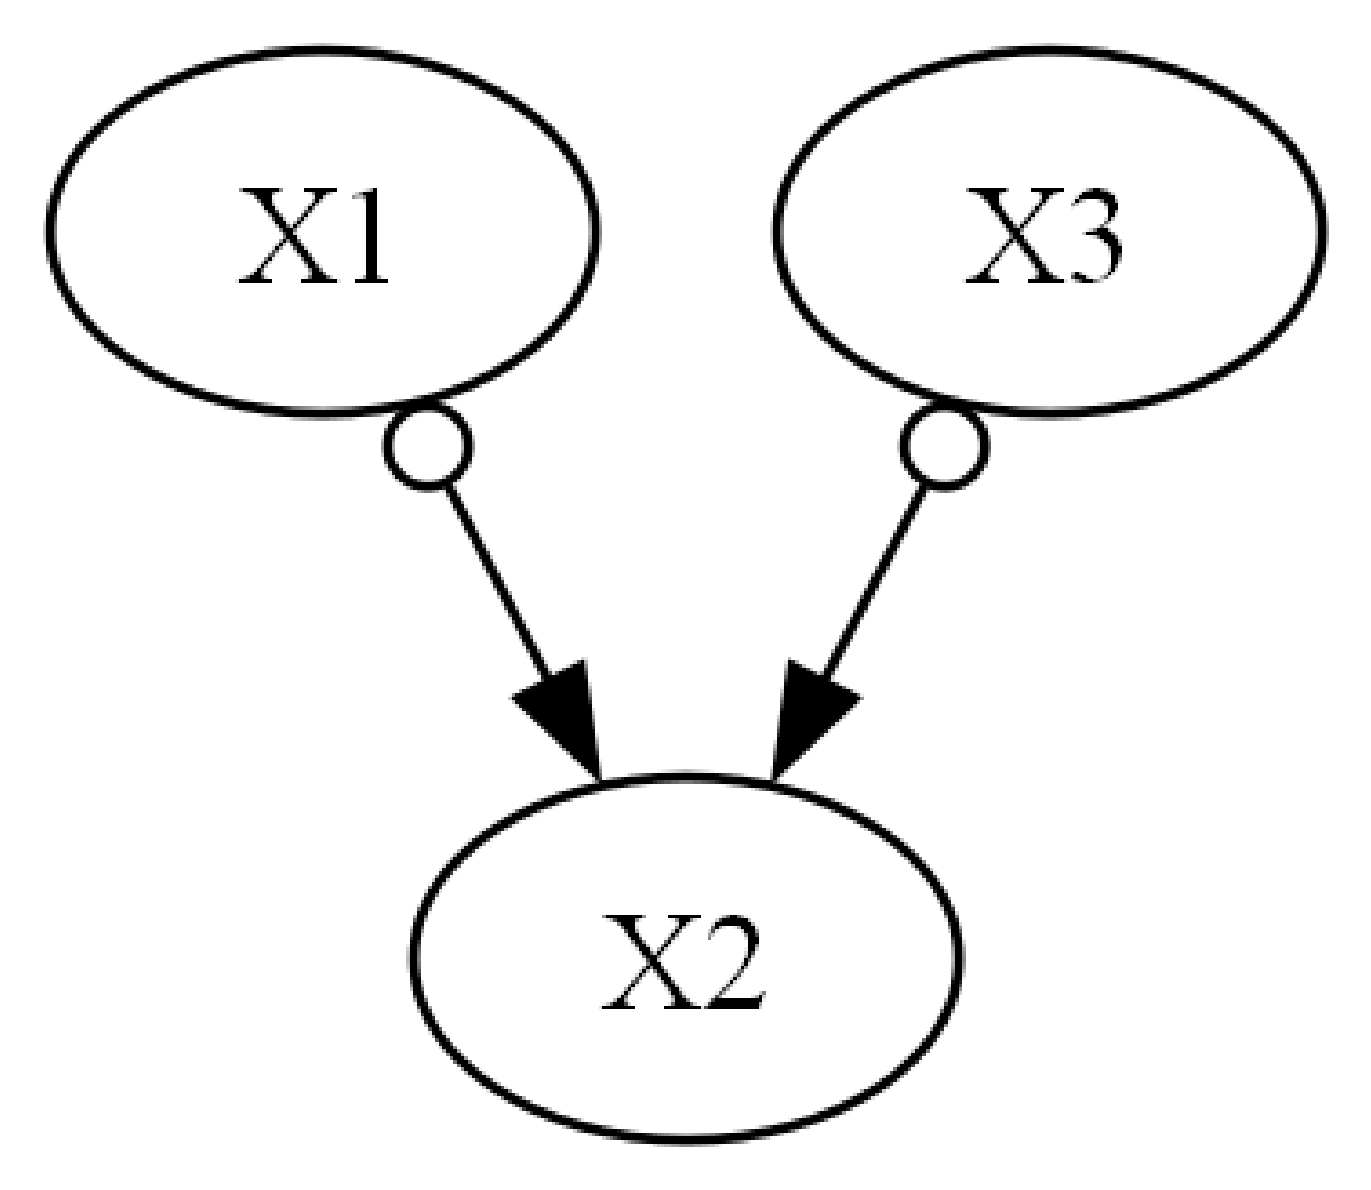

In [18]:
base_cg.draw_pydot_graph()

### 4 node FCI

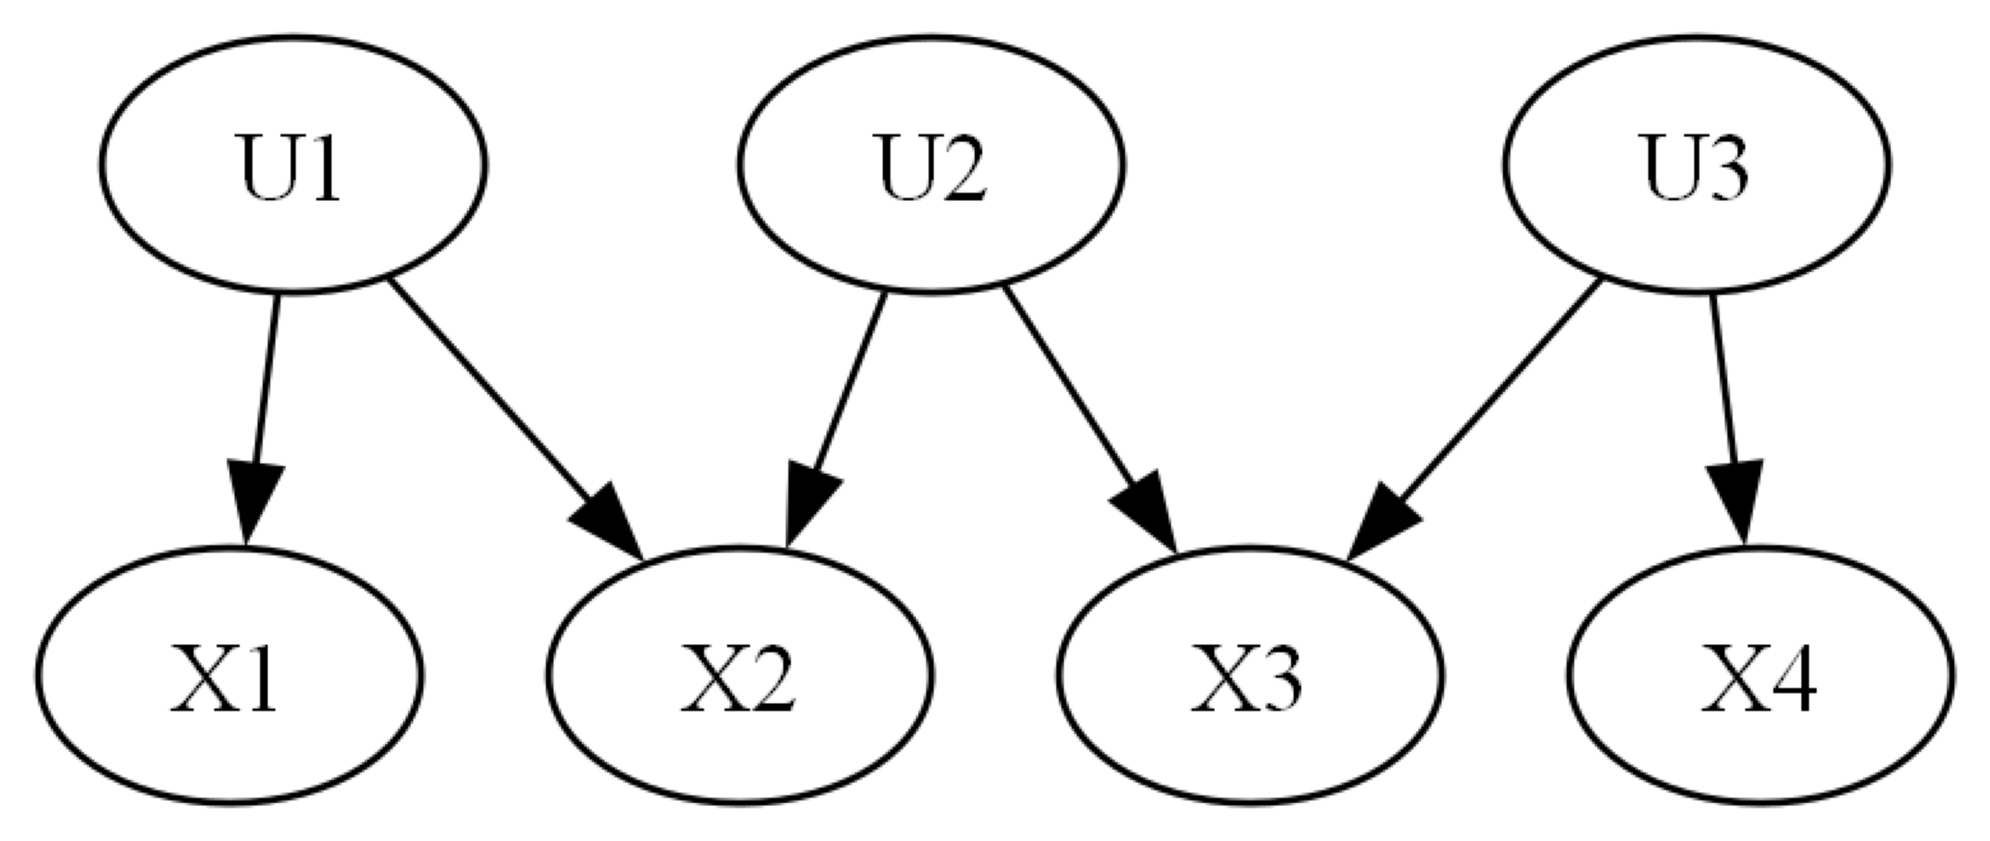

In [19]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "U1", "U2", "U3"]

# Parent dictionary
parent_dict = {
    "X1": ["U1"],               # X1 has no parents
    "X2": ["U1", "U2"],           # X2 has X1 as a parent
    "X3": ["U2", "U3"],           # X3 has X1 as a parent
    "X4": ["U3"],
    "U1": [],
    "U2": [],
    "U3": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [20]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([ 0.26256078, -0.60655463,  1.9927644 ,  3.10224267, -0.23415337,
       -0.23413696,  1.57921282])

In [21]:
# remove confounders from X
X = X[:,:4]
X

array([[ 0.26256078, -0.60655463,  1.9927644 ,  3.10224267],
       [ 0.30170498, -0.69324187, -1.12875793, -2.37669794],
       [-2.63294191, -2.88261531, -0.95948605,  1.7798961 ],
       ...,
       [-0.77880783, -2.21262061, -0.09957637,  1.35603184],
       [ 0.63152595, -0.68866676,  1.30867665,  1.80940473],
       [ 0.99302981, -0.43395547, -1.40977871, -0.99839204]])

In [22]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3', 'X4']}, cluster_edges = [])
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3'], 'C2': ['X4']}, cluster_edges = [], \
                         cluster_bidirected_edges=[('C1', 'C2')])

In [23]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [24]:
cluster_cg, cluster_edges = cluster_fci.run()

C2 phase, Depth=0, working on node 3: 100%|██████████| 1/1 [00:00<?, ?it/s, duration: 0.00sec]


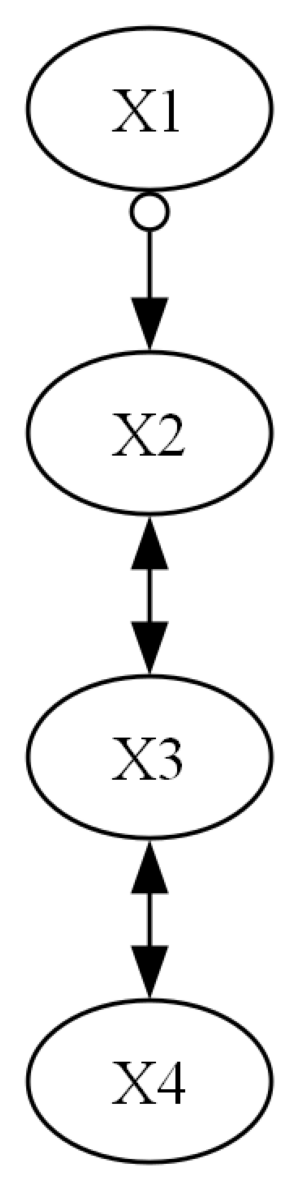

In [25]:
cluster_cg.draw_pydot_graph()

In [26]:
from causallearn.search.ConstraintBased.FCI import fci

In [27]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(3, )
node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=1, working on node 3: 100%|██████████| 4/4 [00:00<?, ?it/s]

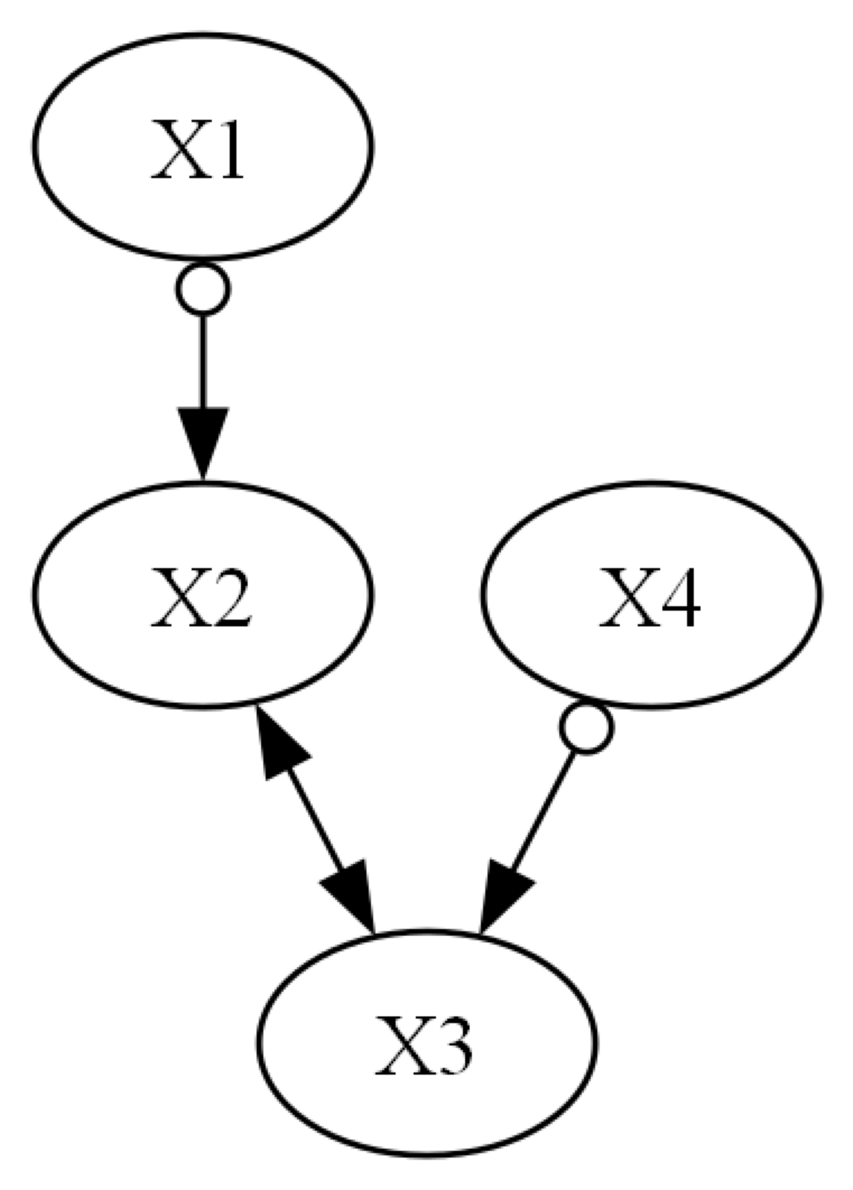

In [28]:
base_cg.draw_pydot_graph()

### 5 node FCI

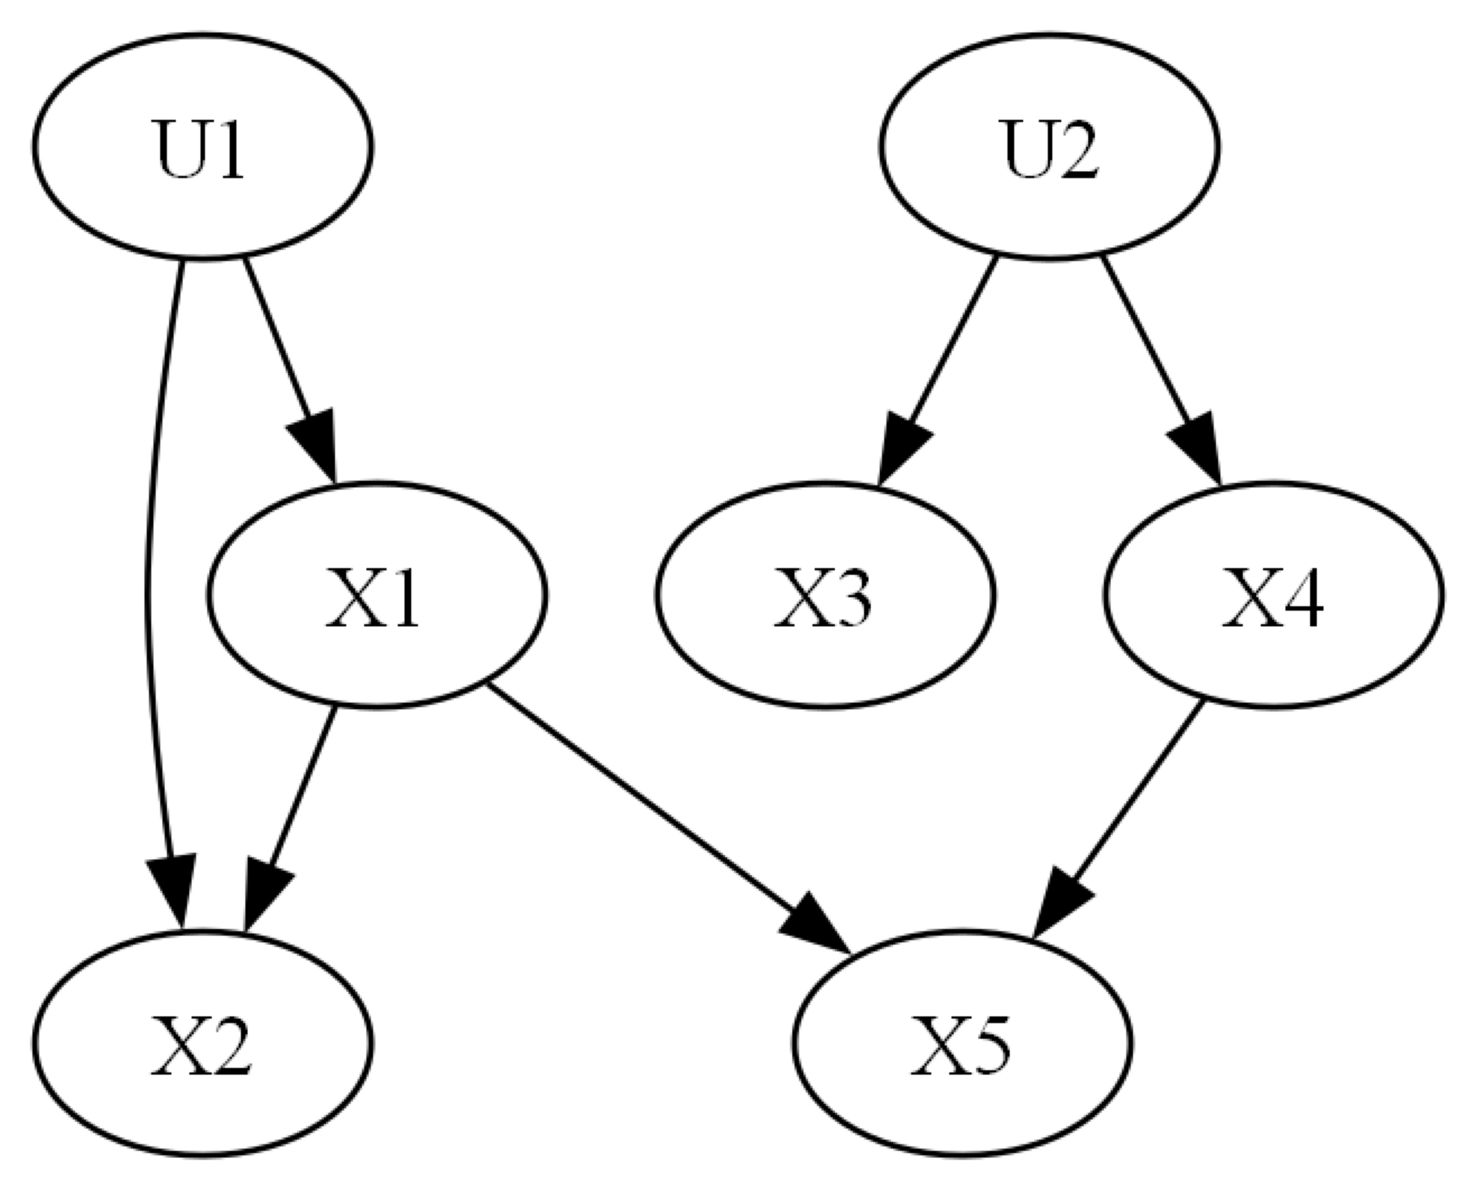

In [29]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "X5", "U1", "U2"]

# Parent dictionary
parent_dict = {
    "X1": ["U1"],               
    "X2": ["X1", "U1"],           
    "X3": ["U2"],           
    "X4": ["U2"],
    "X5": ["X1", "X4"],
    "U1": [],
    "U2": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [30]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([ 0.2625772 , -0.10982406,  2.22690135,  3.10224267,  3.13066649,
       -0.23413696,  1.57921282])

In [31]:
# remove confounders from X
X = X[:,:5]
X

array([[ 0.2625772 , -0.10982406,  2.22690135,  3.10224267,  3.13066649],
       [ 1.009397  ,  0.78188489, -1.3707202 , -2.37669794, -1.83303069],
       [-3.13722153, -5.11181276,  0.45281765,  1.7798961 , -2.26534951],
       ...,
       [-1.59892848, -3.44051812,  1.09157525,  1.35603184, -0.61392761],
       [ 0.52295022,  0.29091925,  1.87388818,  1.80940473,  1.87571916],
       [ 1.15302764,  0.35114724, -1.93770146, -0.99839204,  0.52256052]])

In [32]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3', 'X4', 'X5']}, cluster_edges = [])
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4', 'X5']}, cluster_edges = [('C1', 'C2')], \
                         cluster_bidirected_edges=[])

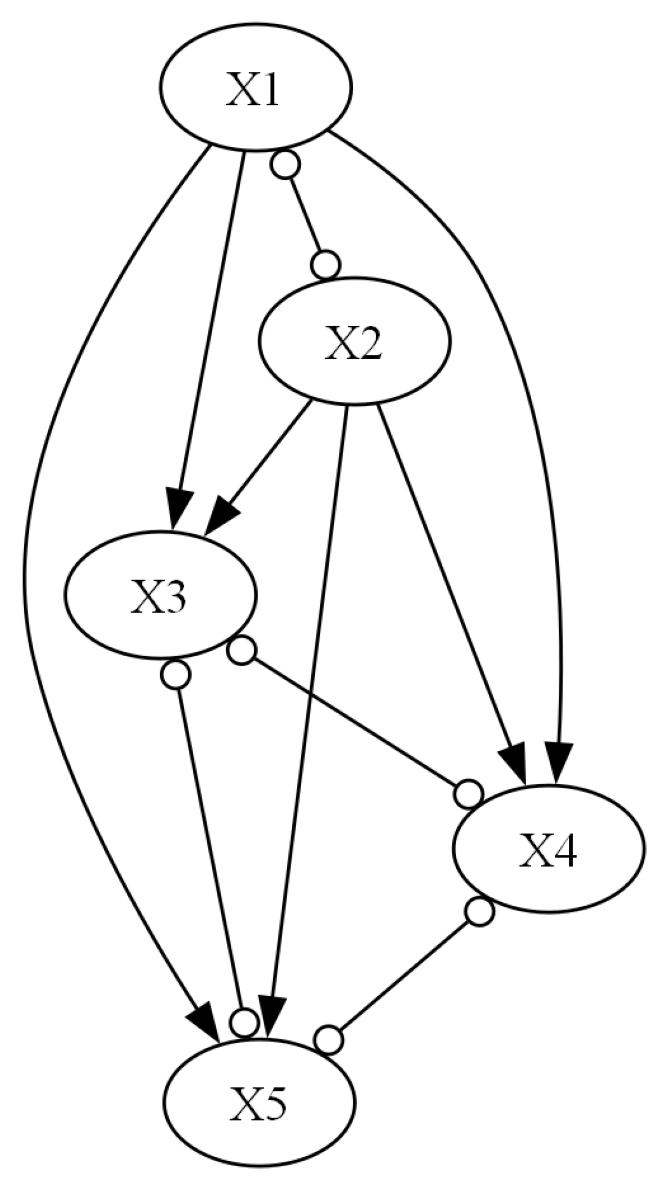

In [33]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [34]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [35]:
cluster_cg, cluster_edges = cluster_fci.run()

C2 phase, Depth=1, working on node 4: 100%|██████████| 3/3 [00:00<?, ?it/s, duration: 0.02sec]


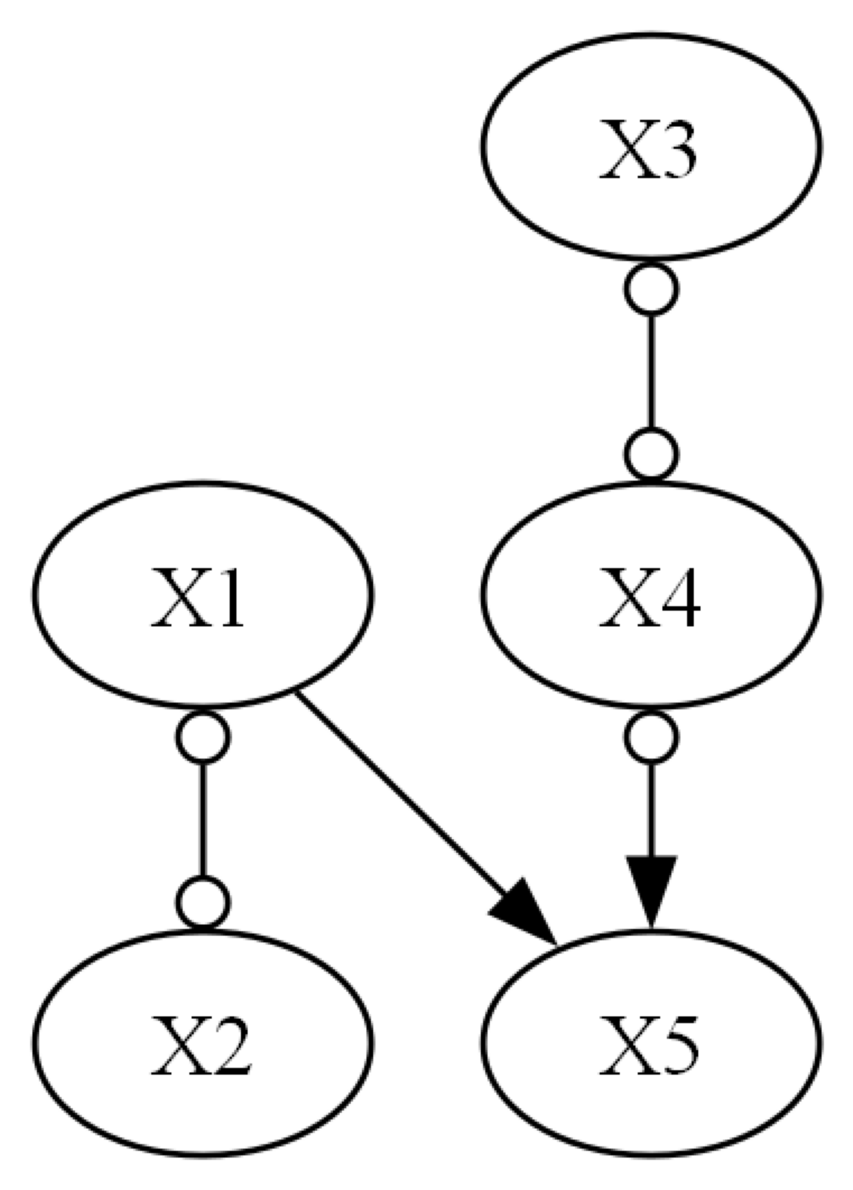

In [36]:
cluster_cg.draw_pydot_graph()

In [37]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(5)
# node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=1, working on node 4: 100%|██████████| 5/5 [00:00<?, ?it/s]

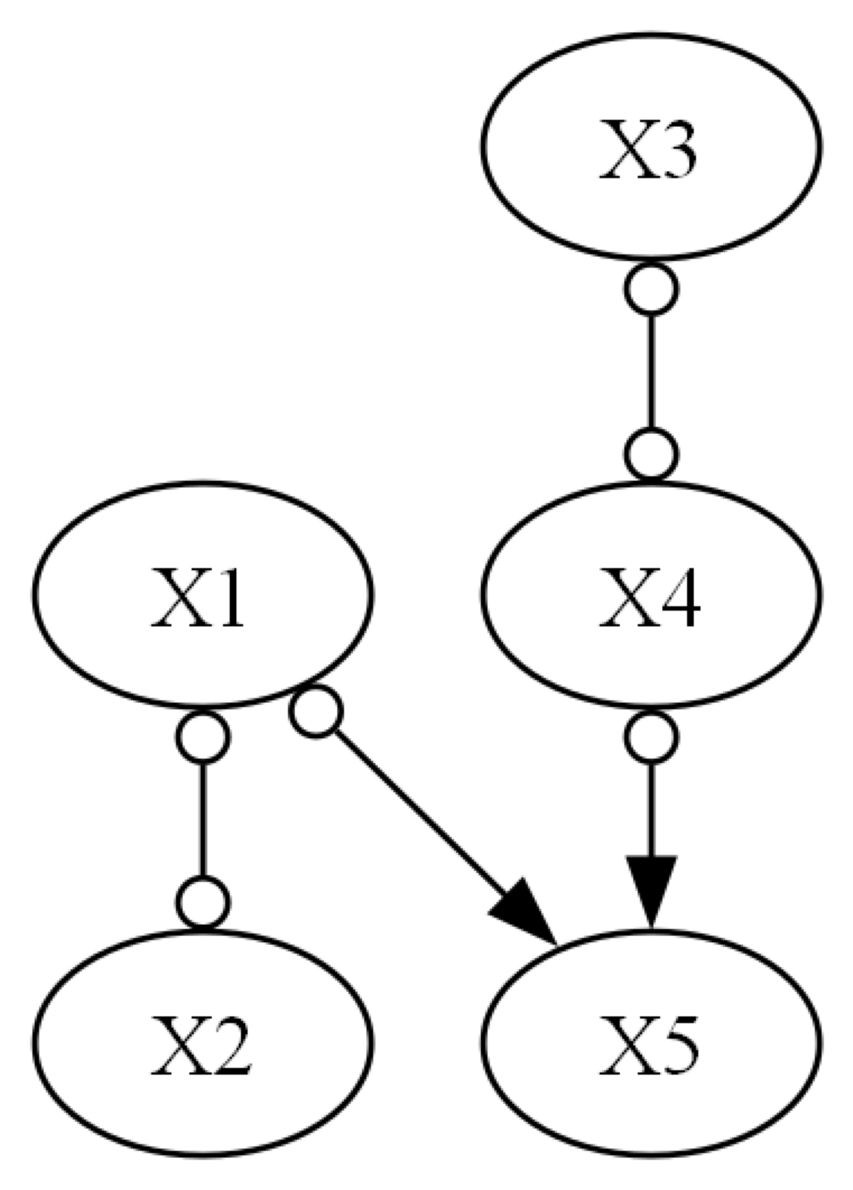

In [38]:
base_cg.draw_pydot_graph()

### 6 node FCI - number 1

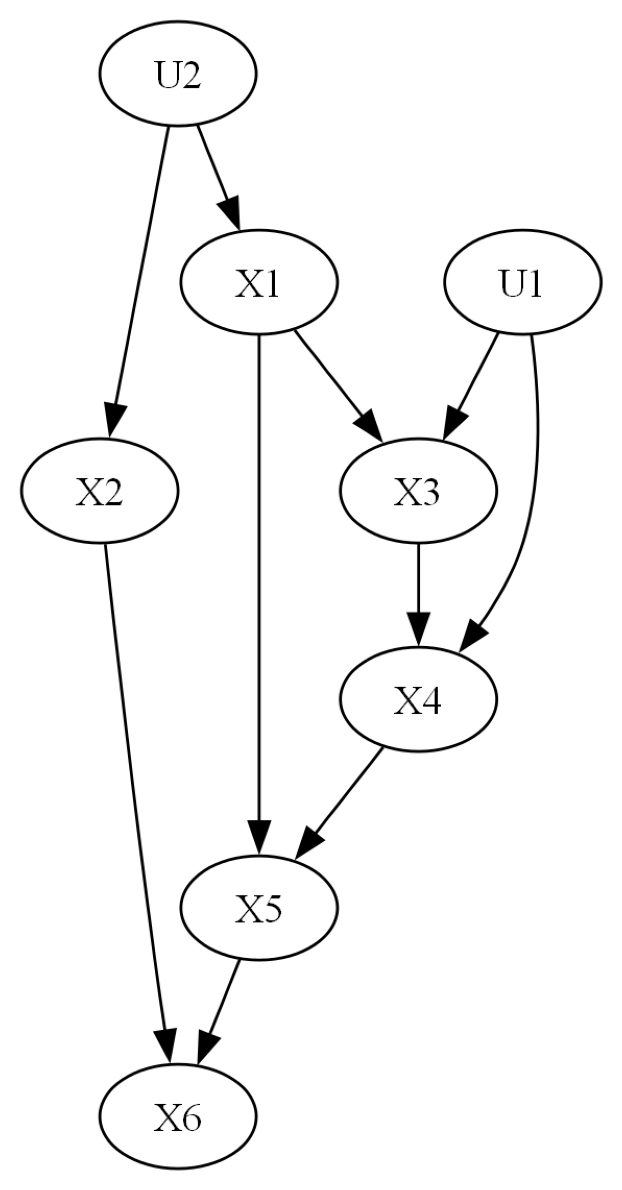

In [39]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "X5", "X6", "U1", "U2"]

# Parent dictionary
# Make sure nodes are put into topological ordering
parent_dict = {
    "X1": ["U2"],           
    "X2": ["U2"],
    "X3": ["U1", "X1"],               
    "X4": ["X3", "U1"], 
    "X5": ["X1", "X4"],
    "X6": ["X2", "X5"],
    "U1": [],
    "U2": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [40]:
true_mag = truth
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U1', cg = truth))
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U2', cg = truth))
# Add edge due to inducing path
node1 = ClusterDAG.get_node_by_name('X1', cg = truth)
node2 = ClusterDAG.get_node_by_name('X4', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.TAIL, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)
# Add bidirected edge due to latent confounding
node1 = ClusterDAG.get_node_by_name('X1', cg = truth)
node2 = ClusterDAG.get_node_by_name('X2', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)

True

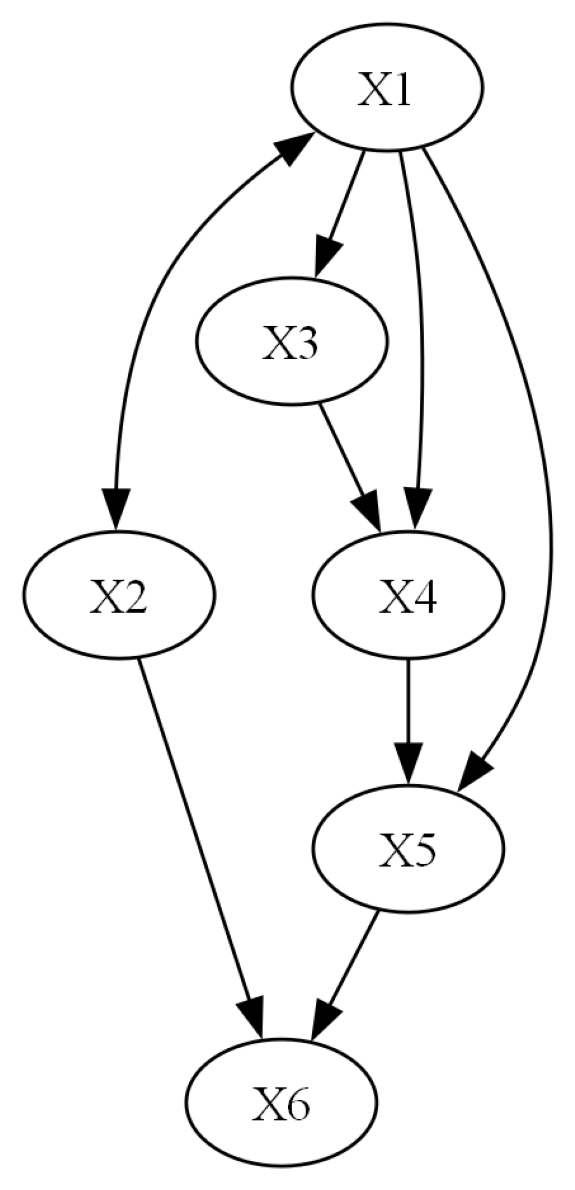

In [41]:
true_mag.draw_pydot_graph()

In [42]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([1.26414888, 0.62917043, 3.49105024, 6.59329291, 7.62328842,
       8.01832189, 1.57921282, 0.76743473])

In [43]:
# remove confounders from X
X = X[:,:6]
X

array([[ 1.26414888,  0.62917043,  3.49105024,  6.59329291,  7.62328842,
         8.01832189],
       [-1.03176192, -0.01972749, -3.22009744, -5.41074503, -6.20054467,
        -8.1335524 ],
       [-2.43757931, -1.11050085, -3.27807518, -4.62285067, -5.59478121,
        -6.93105837],
       ...,
       [ 0.72333001,  0.83390522,  1.65871638,  2.18126592,  2.45222444,
         4.29334771],
       [-2.92327116, -1.66654366, -0.91912746, -0.08885745, -3.11737733,
        -5.18740362],
       [-2.42791104, -0.43020362, -1.57591246, -0.63839046, -3.49562021,
        -4.39478084]])

In [44]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']}, \
#                          cluster_edges = [])

In [45]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4', 'X5', 'X6']}, \
#                          cluster_edges = [('C1', 'C2')])

In [46]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C2'), ('C2', 'C3'), ('C1', 'C3')], \
                         cluster_bidirected_edges= [])

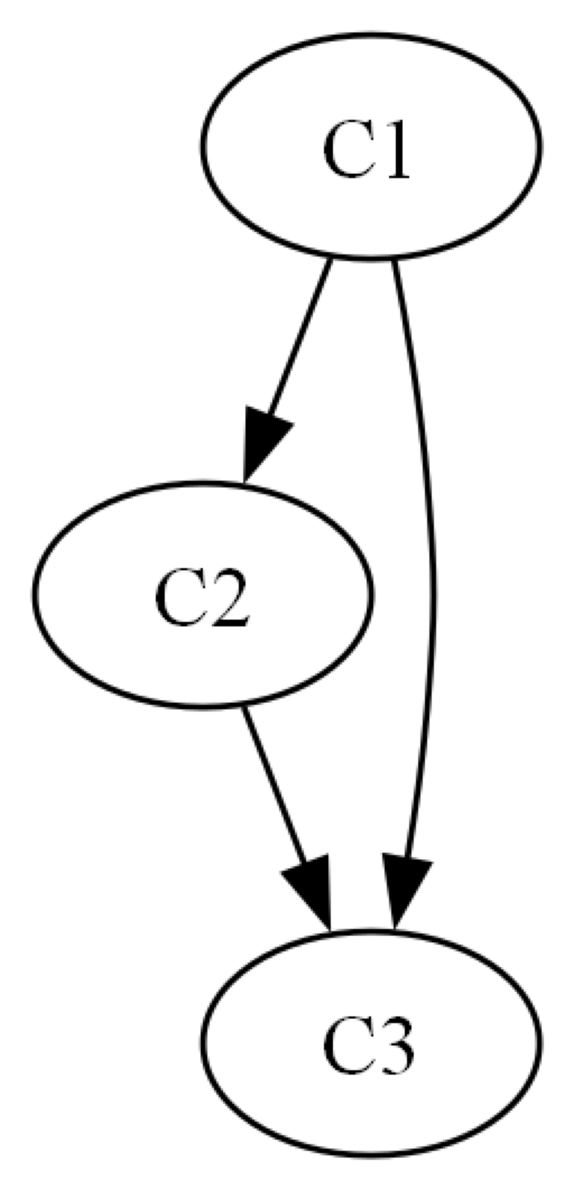

In [47]:
cluster_dag.cluster_graph.draw_pydot_graph()

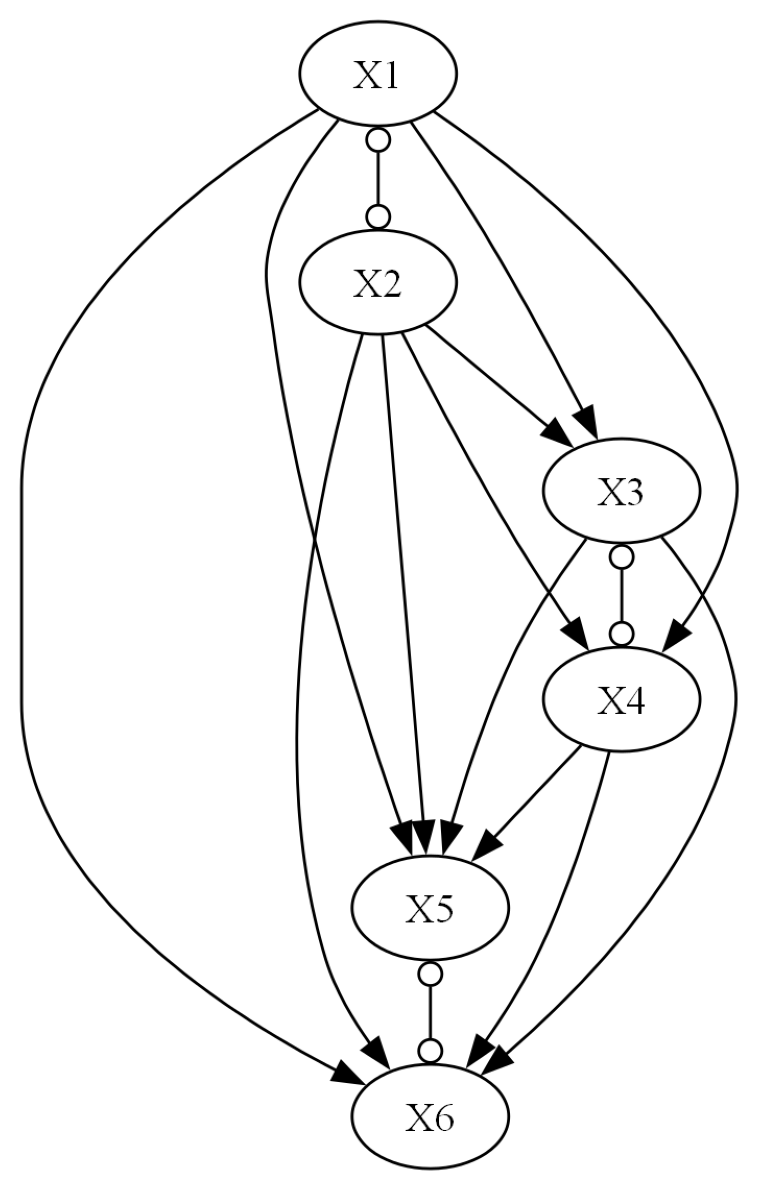

In [48]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [49]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [50]:
cluster_cg, cluster_edges = cluster_fci.run()

C3 phase, Depth=2, working on node 5: 100%|██████████| 2/2 [00:00<?, ?it/s, duration: 0.02sec]

X4 --> X5
X5 --> X6


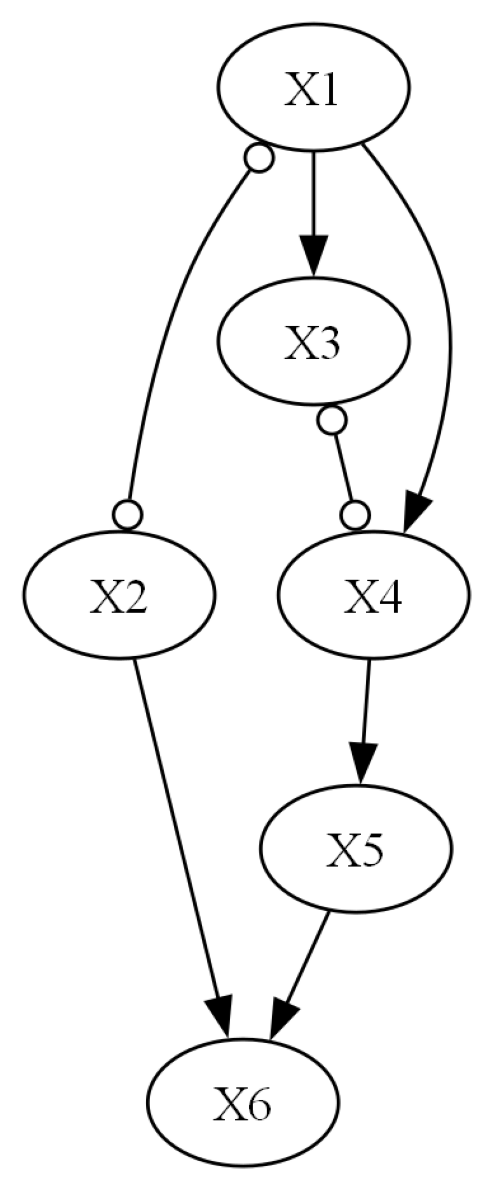

In [51]:
cluster_cg.draw_pydot_graph()

In [52]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(5)
# node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 376.93it/s]

X4 --> X3


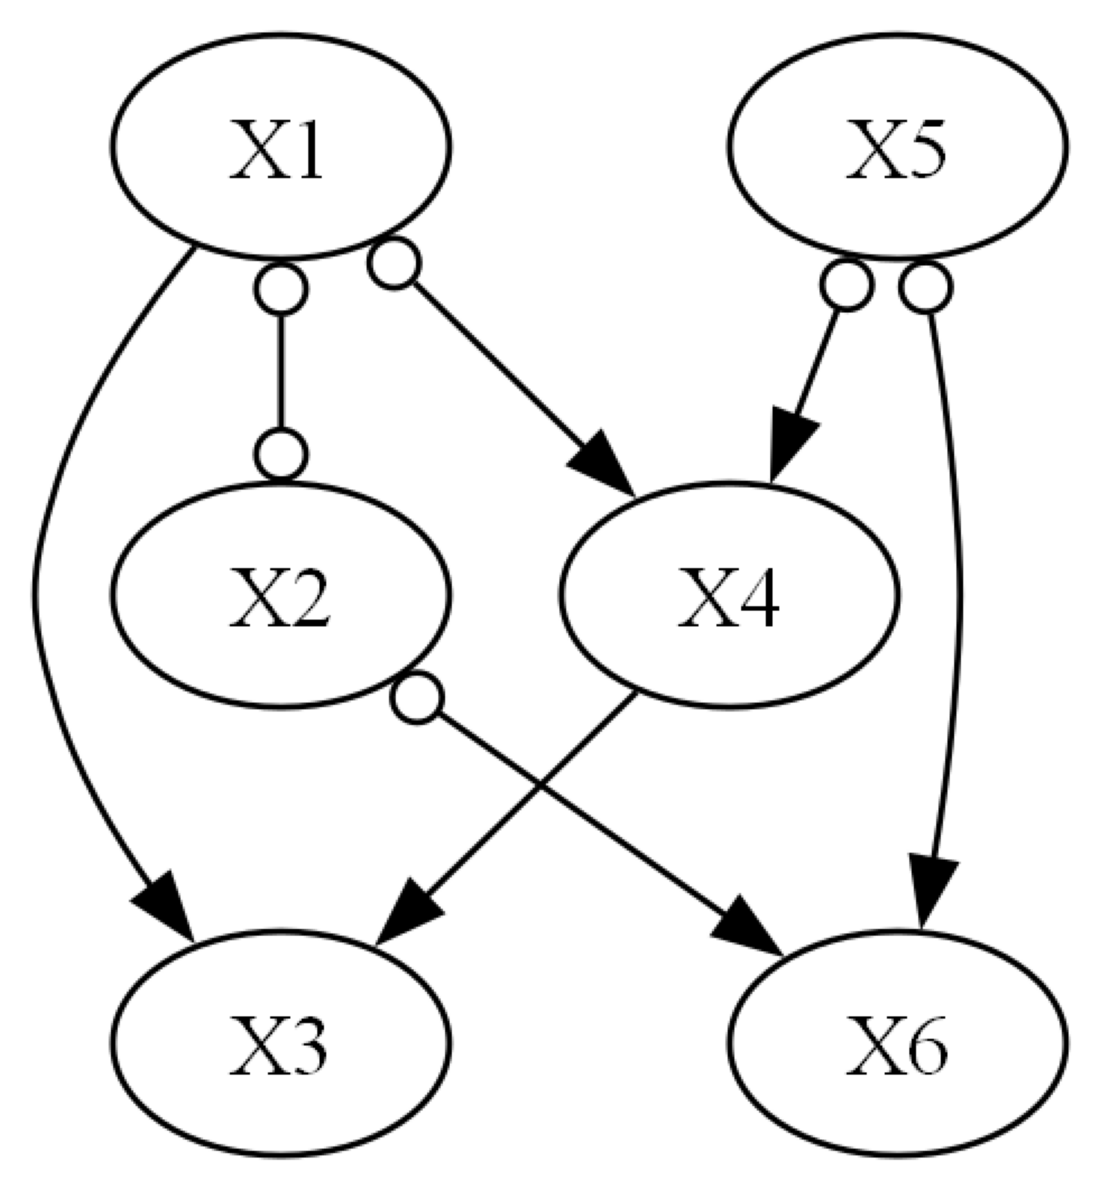

In [53]:
base_cg.draw_pydot_graph()

SID is set to false, as SID is not defined for PAGs. Its outputs do not make sense. 

In [54]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

NameError: name 'Evaluator' is not defined

In [52]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 7, 'false_positive': 0, 'false_negative': 1, 'true_negative': 7, 'precision': 1.0, 'recall': 0.875, 'f1_score': 0.9333333333333333}
Arrow confusion:  {'true_positive': 5.0, 'false_positive': 0.0, 'false_negative': 4.0, 'true_negative': 27.0, 'precision': 1.0, 'recall': 0.5555555555555556, 'f1_score': 0.7142857142857143, 'true_positive_ce': 5.0, 'false_positive_ce': 0.0, 'false_negative_ce': 3.0, 'true_negative_ce': 28.0, 'precision_ce': 1.0, 'recall_ce': 0.625, 'f1_score_ce': 0.7692307692307693}
SHD:  1
SID:  {'sid_lower': None}


### 6 node FCI - number 2

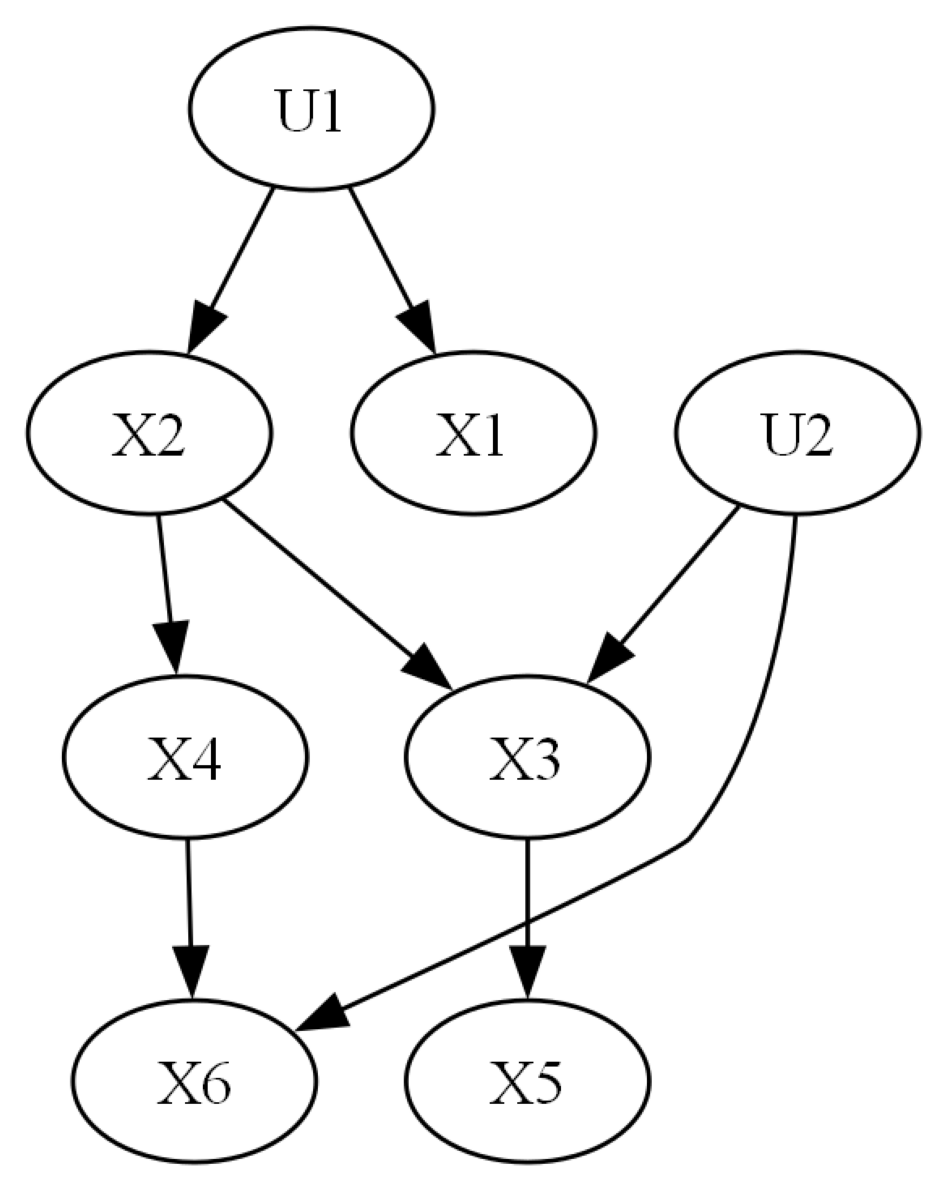

In [53]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "X5", "X6", "U1", "U2"]

# Parent dictionary
# Make sure nodes are put into topological ordering
parent_dict = {
    "X1": ["U1"],           
    "X2": ["U1"],
    "X3": ["X2", "U2"],               
    "X4": ["X2"], 
    "X5": ["X3"],
    "X6": ["X4", "U2"],
    "U1": [],
    "U2": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [54]:
true_mag = truth
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U1', cg = truth))
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U2', cg = truth))
# Add edge due to inducing path
node1 = ClusterDAG.get_node_by_name('X3', cg = truth)
node2 = ClusterDAG.get_node_by_name('X6', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)
# Add bidirected edge due to latent confounding
node1 = ClusterDAG.get_node_by_name('X1', cg = truth)
node2 = ClusterDAG.get_node_by_name('X2', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)

True

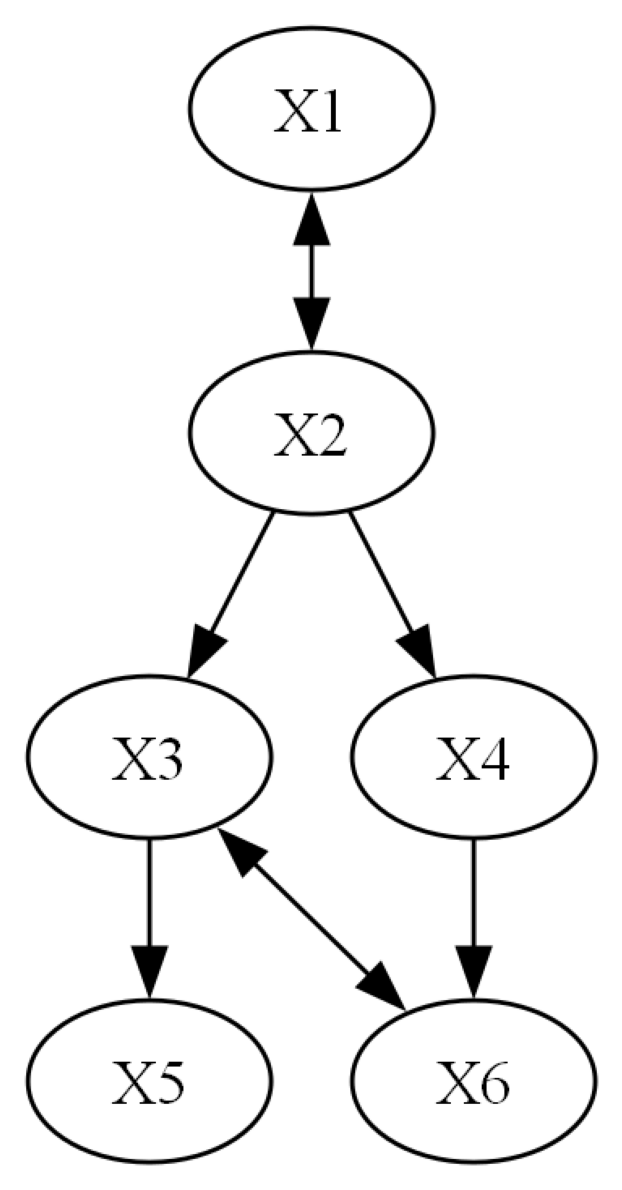

In [55]:
true_mag.draw_pydot_graph()

In [56]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([2.07592697, 1.44094851, 2.85607178, 2.96397837, 2.62191841,
       3.49727614, 1.57921282, 0.76743473])

In [57]:
# remove confounders from X
X = X[:,:6]
X

array([[ 2.07592697,  1.44094851,  2.85607178,  2.96397837,  2.62191841,
         3.49727614],
       [-2.19439222, -1.18235779, -2.20806301, -1.64808754, -1.96610074,
        -4.12365532],
       [-0.94530292,  0.38177554, -1.95099672, -1.03052816, -0.48534796,
        -2.68105265],
       ...,
       [-0.88205414, -0.77147893,  1.76929159, -0.49269816,  1.3169201 ,
         2.36367281],
       [-1.42863195, -0.17190446,  0.33760004,  0.30854216,  0.23235131,
        -1.23975628],
       [-1.43776579,  0.55994163,  0.42179496,  1.50080641, -0.00752374,
         0.03836136]])

In [58]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C2'), ('C2', 'C3')], \
                         cluster_bidirected_edges= [('C2', 'C3')])

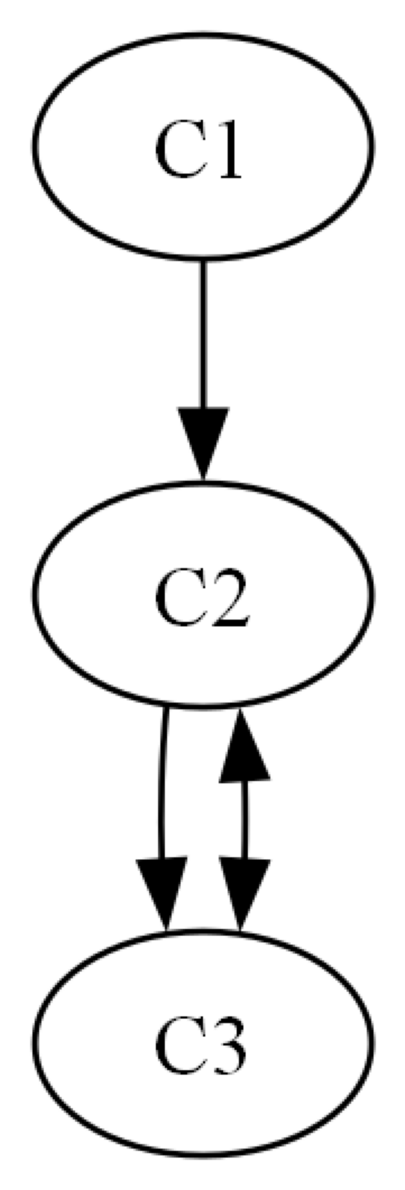

In [59]:
cluster_dag.cluster_graph.draw_pydot_graph()

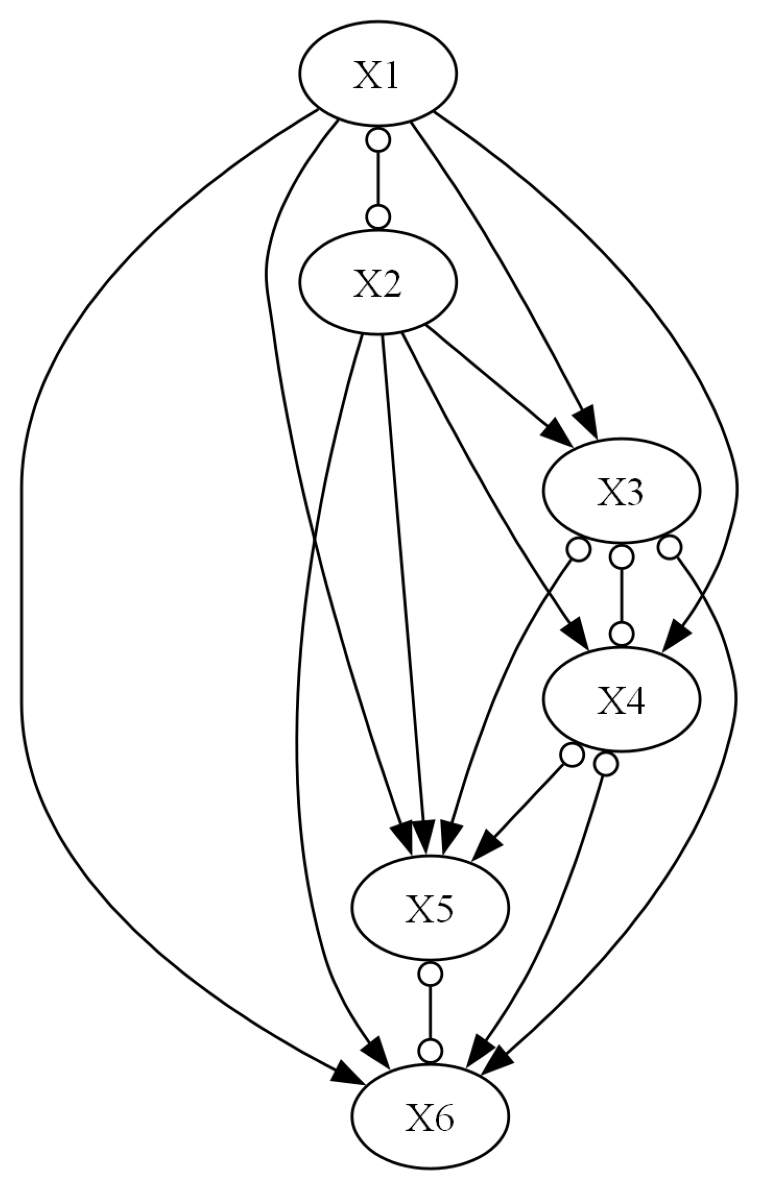

In [60]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [61]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [62]:
cluster_cg, cluster_edges = cluster_fci.run()

C3 phase, Depth=2, working on node 5: 100%|██████████| 2/2 [00:00<?, ?it/s, duration: 0.00sec]

X3 --> X5
X4 --> X6


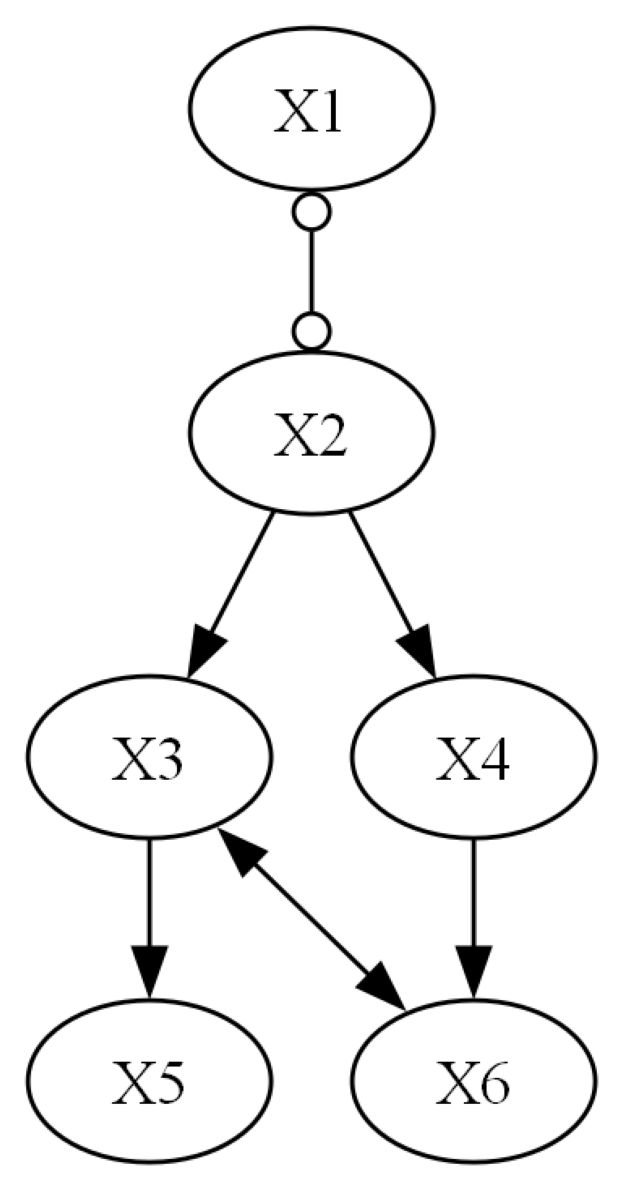

In [63]:
cluster_cg.draw_pydot_graph()

In [64]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(5)
# node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<?, ?it/s]          

X3 --> X5


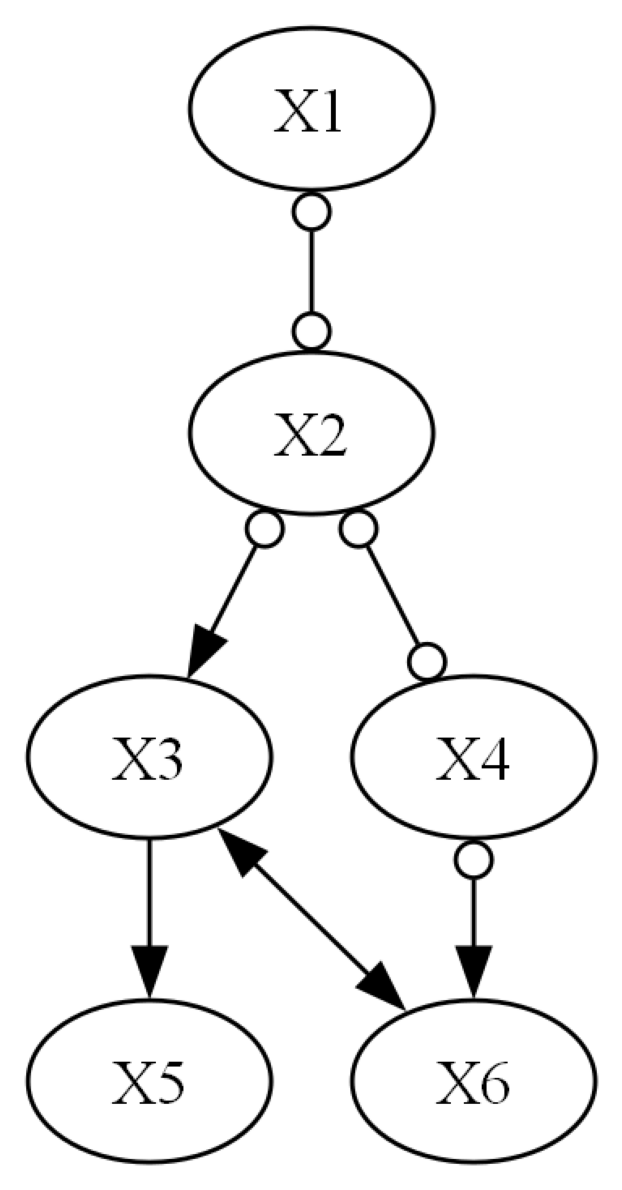

In [65]:
base_cg.draw_pydot_graph()

In [66]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 6, 'false_positive': 0, 'false_negative': 0, 'true_negative': 9, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 5.0, 'false_positive': 0.0, 'false_negative': 3.0, 'true_negative': 28.0, 'precision': 1.0, 'recall': 0.625, 'f1_score': 0.7692307692307693, 'true_positive_ce': 5.0, 'false_positive_ce': 0.0, 'false_negative_ce': 3.0, 'true_negative_ce': 28.0, 'precision_ce': 1.0, 'recall_ce': 0.625, 'f1_score_ce': 0.7692307692307693}
SHD:  2
SID:  {'sid_lower': None}


In [67]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 6, 'false_positive': 0, 'false_negative': 0, 'true_negative': 9, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 6.0, 'false_positive': 0.0, 'false_negative': 2.0, 'true_negative': 28.0, 'precision': 1.0, 'recall': 0.75, 'f1_score': 0.8571428571428571, 'true_positive_ce': 6.0, 'false_positive_ce': 0.0, 'false_negative_ce': 2.0, 'true_negative_ce': 28.0, 'precision_ce': 1.0, 'recall_ce': 0.75, 'f1_score_ce': 0.8571428571428571}
SHD:  2
SID:  {'sid_lower': None}


### 6 node FCI - number 3

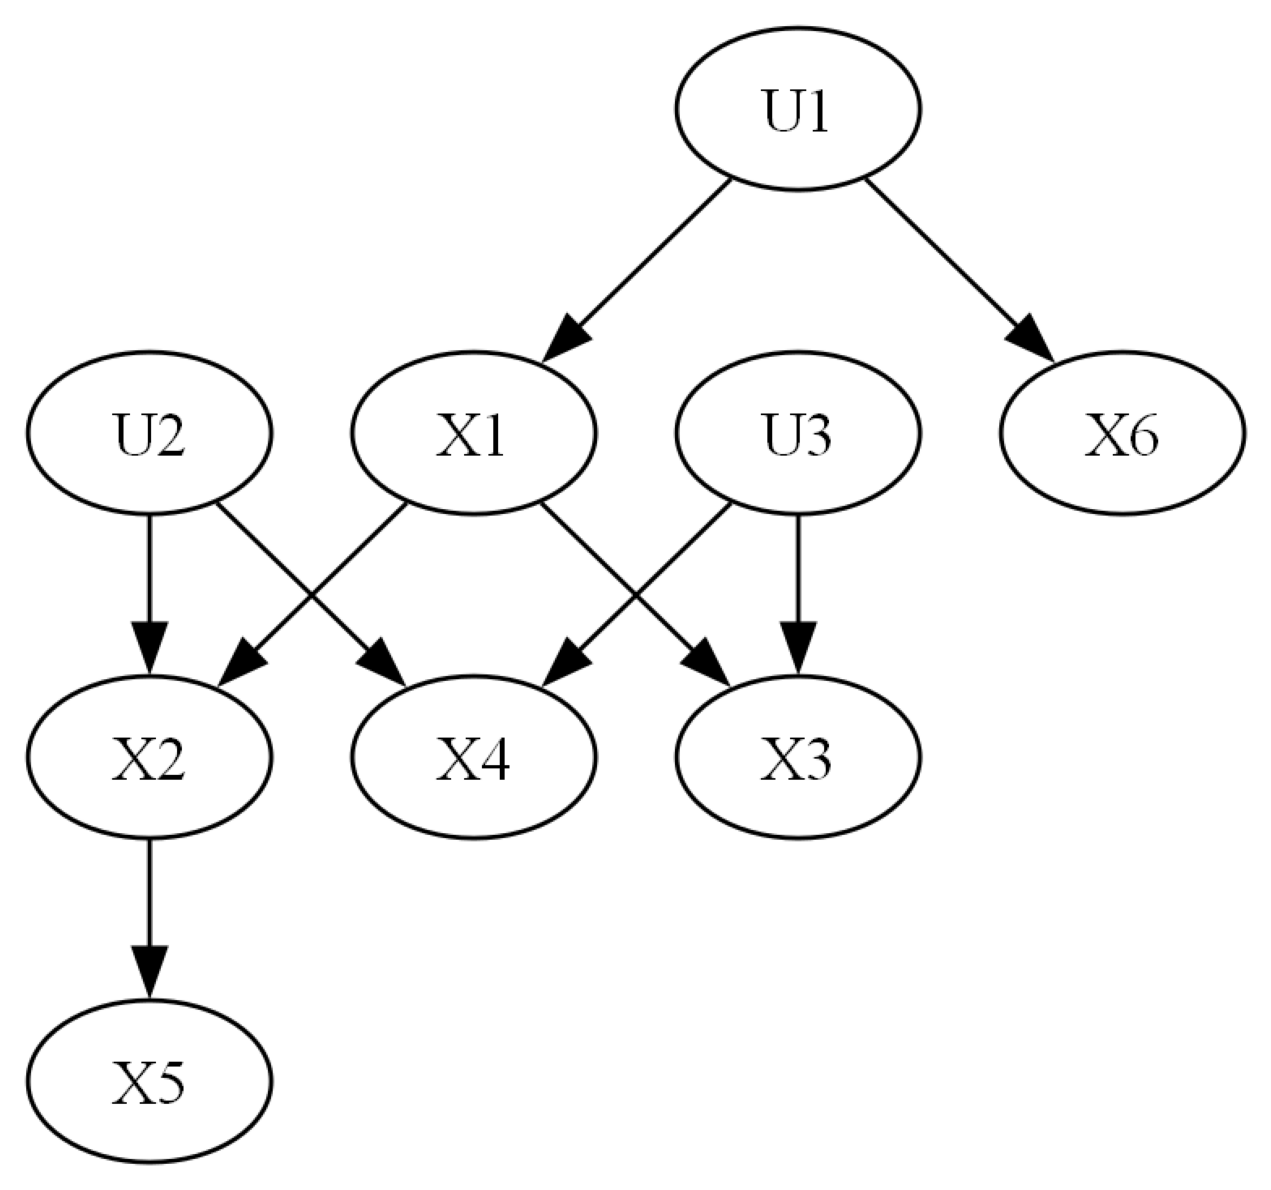

In [68]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "X5", "X6", "U1", "U2", "U3"]

# Parent dictionary
# Make sure nodes are put into topological ordering
parent_dict = {
    "X1": ["U1"],           
    "X2": ["X1", "U2"],
    "X3": ["X1", "U3"],               
    "X4": ["U2", "U3"], 
    "X5": ["X2"],
    "X6": ["U1"],
    "U1": [],
    "U2": [],
    "U3": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [69]:
true_mag = truth
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U1', cg = truth))
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U2', cg = truth))
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U3', cg = truth))
# Add edge due to inducing path
node1 = ClusterDAG.get_node_by_name('X1', cg = truth)
node2 = ClusterDAG.get_node_by_name('X6', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)
# Add bidirected edges due to latent confounding
node1 = ClusterDAG.get_node_by_name('X2', cg = truth)
node2 = ClusterDAG.get_node_by_name('X3', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)
node1 = ClusterDAG.get_node_by_name('X3', cg = truth)
node2 = ClusterDAG.get_node_by_name('X4', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)

True

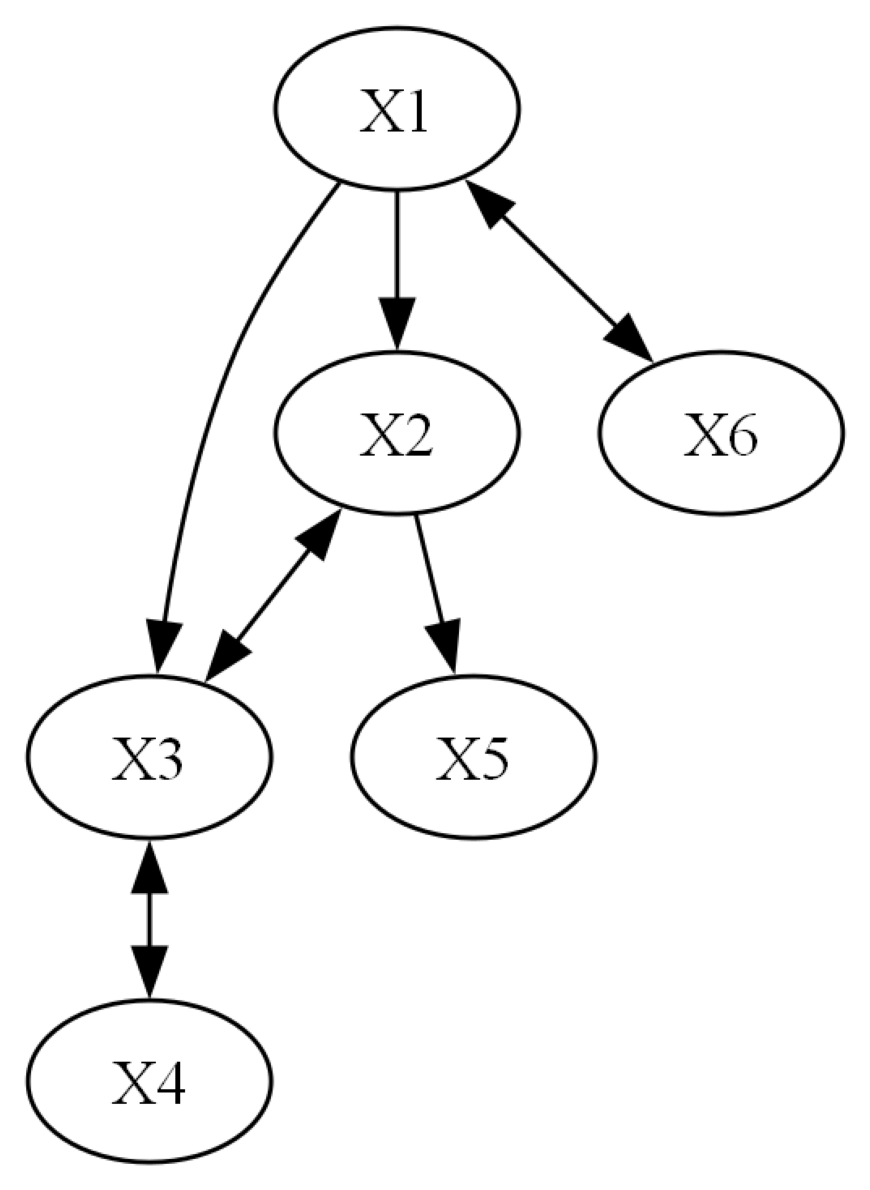

In [70]:
true_mag.draw_pydot_graph()

In [71]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([ 2.07592697,  2.7050974 ,  2.25414112,  1.8209902 ,  2.47094402,
        1.34507586,  1.57921282,  0.76743473, -0.46947439])

In [72]:
# remove confounders from X
X = X[:,:6]
X

array([[ 2.07592697,  2.7050974 ,  2.25414112,  1.8209902 ,  2.47094402,
         1.34507586],
       [-0.01972749, -1.4959763 , -0.17120991, -0.45662152, -3.40925654,
        -2.28720536],
       [-1.4524068 , -2.75378791, -1.13775161, -1.26584729, -2.68625971,
        -1.96913091],
       ...,
       [ 0.36195746, -2.15557537,  1.51389277,  2.0082814 , -2.29978207,
         2.94309945],
       [ 2.84977439,  3.05742378,  3.06222901, -1.24619098,  1.4169281 ,
         0.75125336],
       [ 0.82388967,  0.80153437,  0.95269842, -1.94598947,  2.62356506,
        -0.96590443]])

In [73]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C2'), ('C1', 'C3')], \
                         cluster_bidirected_edges= [('C1', 'C2'), ('C1', 'C3')])

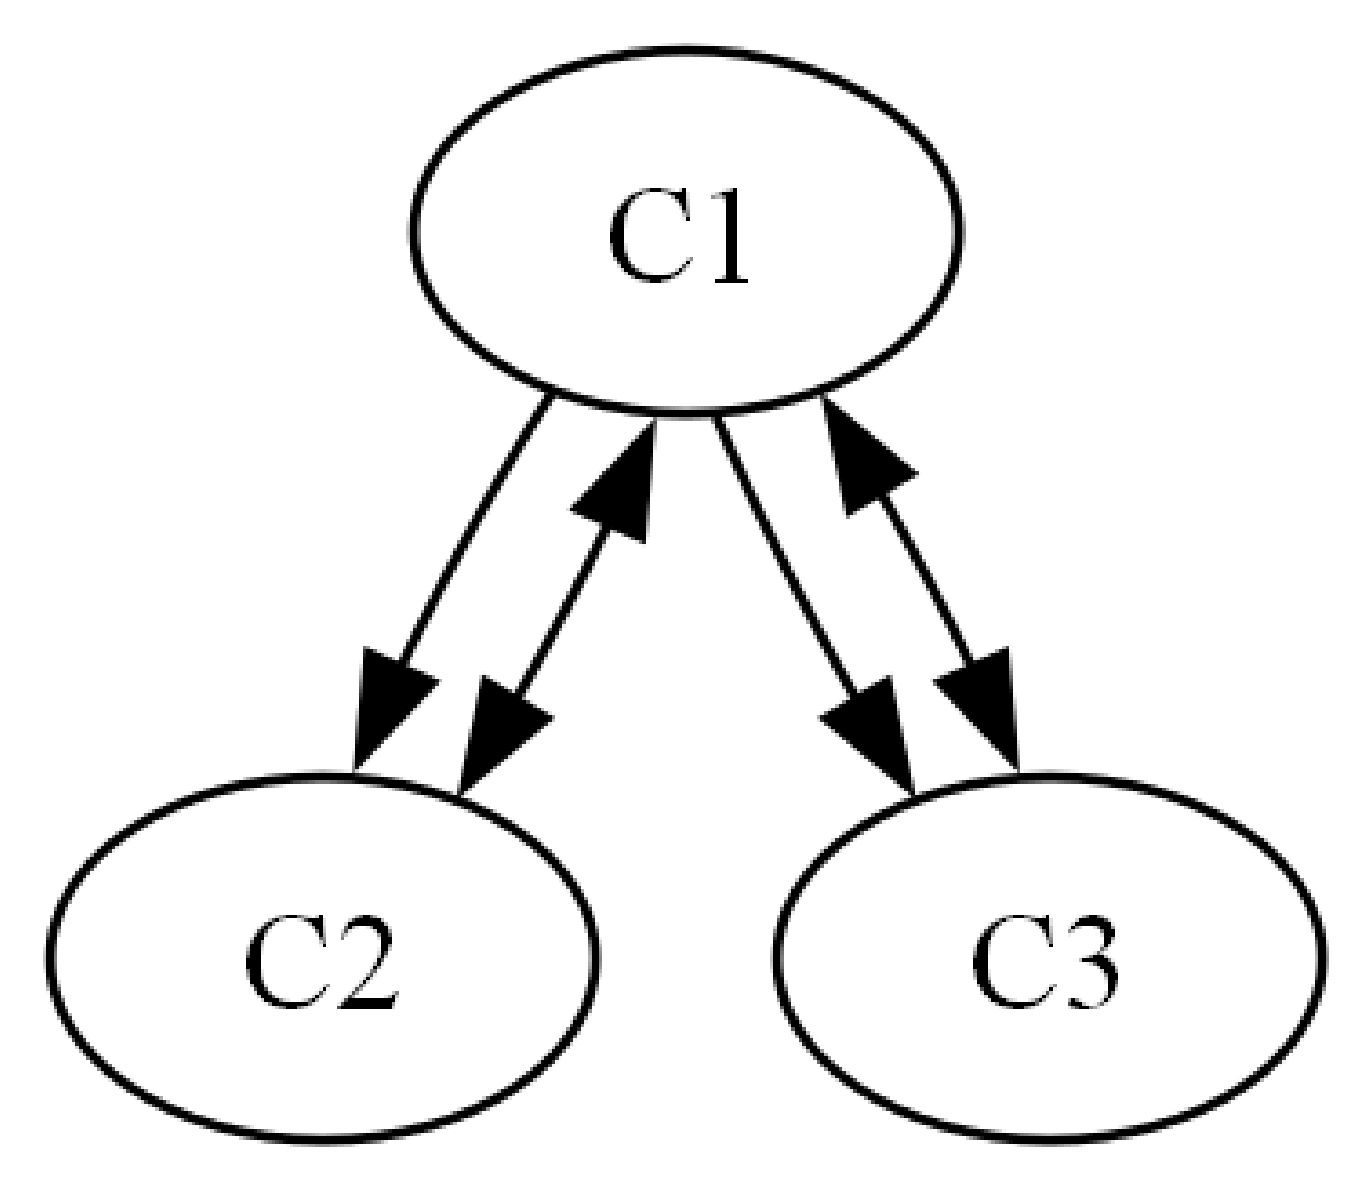

In [74]:
cluster_dag.cluster_graph.draw_pydot_graph()

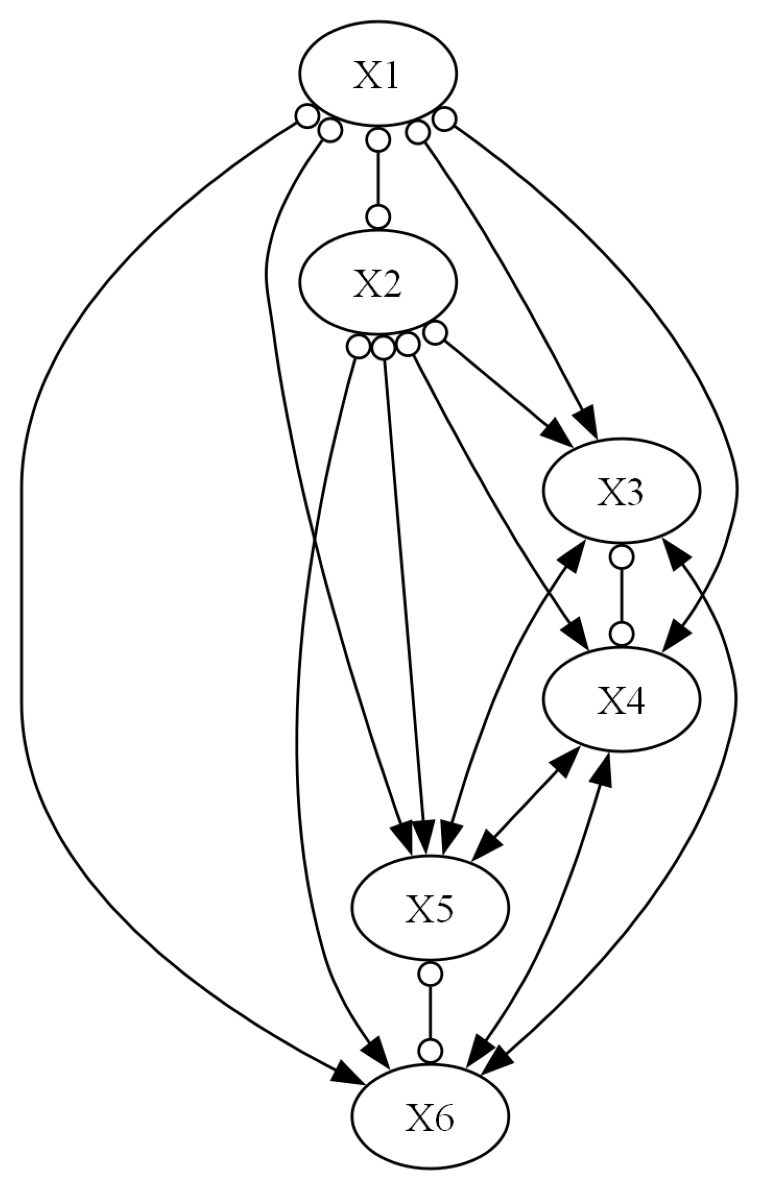

In [75]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [76]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [77]:
cluster_cg, cluster_edges = cluster_fci.run()

C3 phase, Depth=2, working on node 5: 100%|██████████| 2/2 [00:00<?, ?it/s, duration: 0.02sec]

X2 --> X5


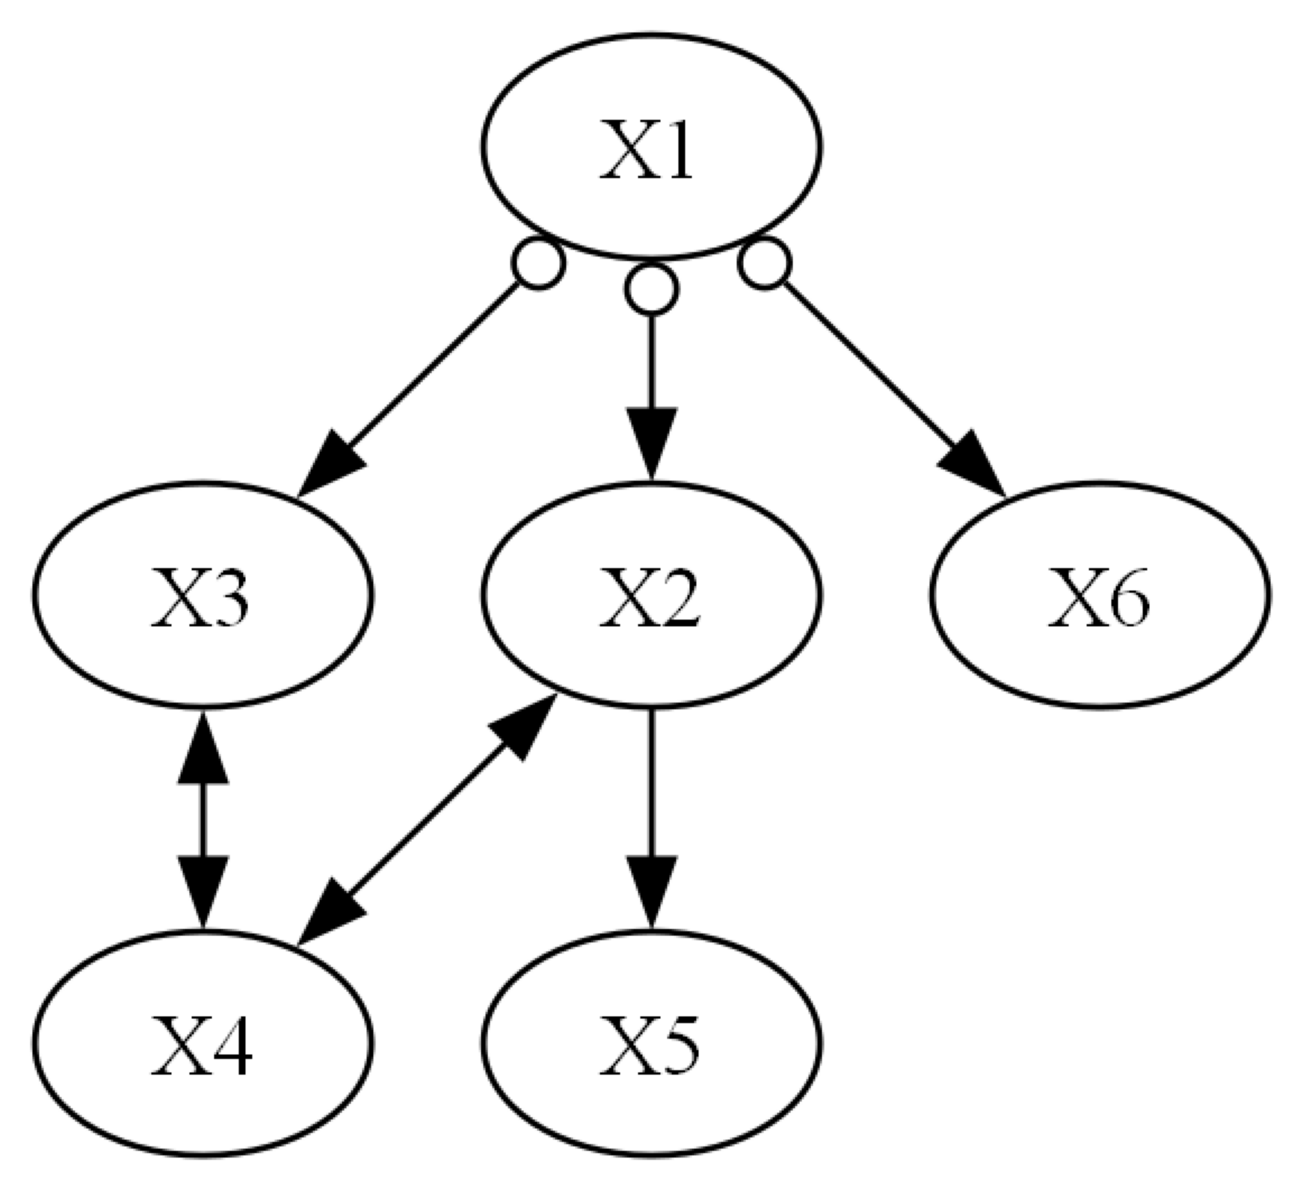

In [78]:
cluster_cg.draw_pydot_graph()

In [79]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(5)
# node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<?, ?it/s]          

X2 --> X5


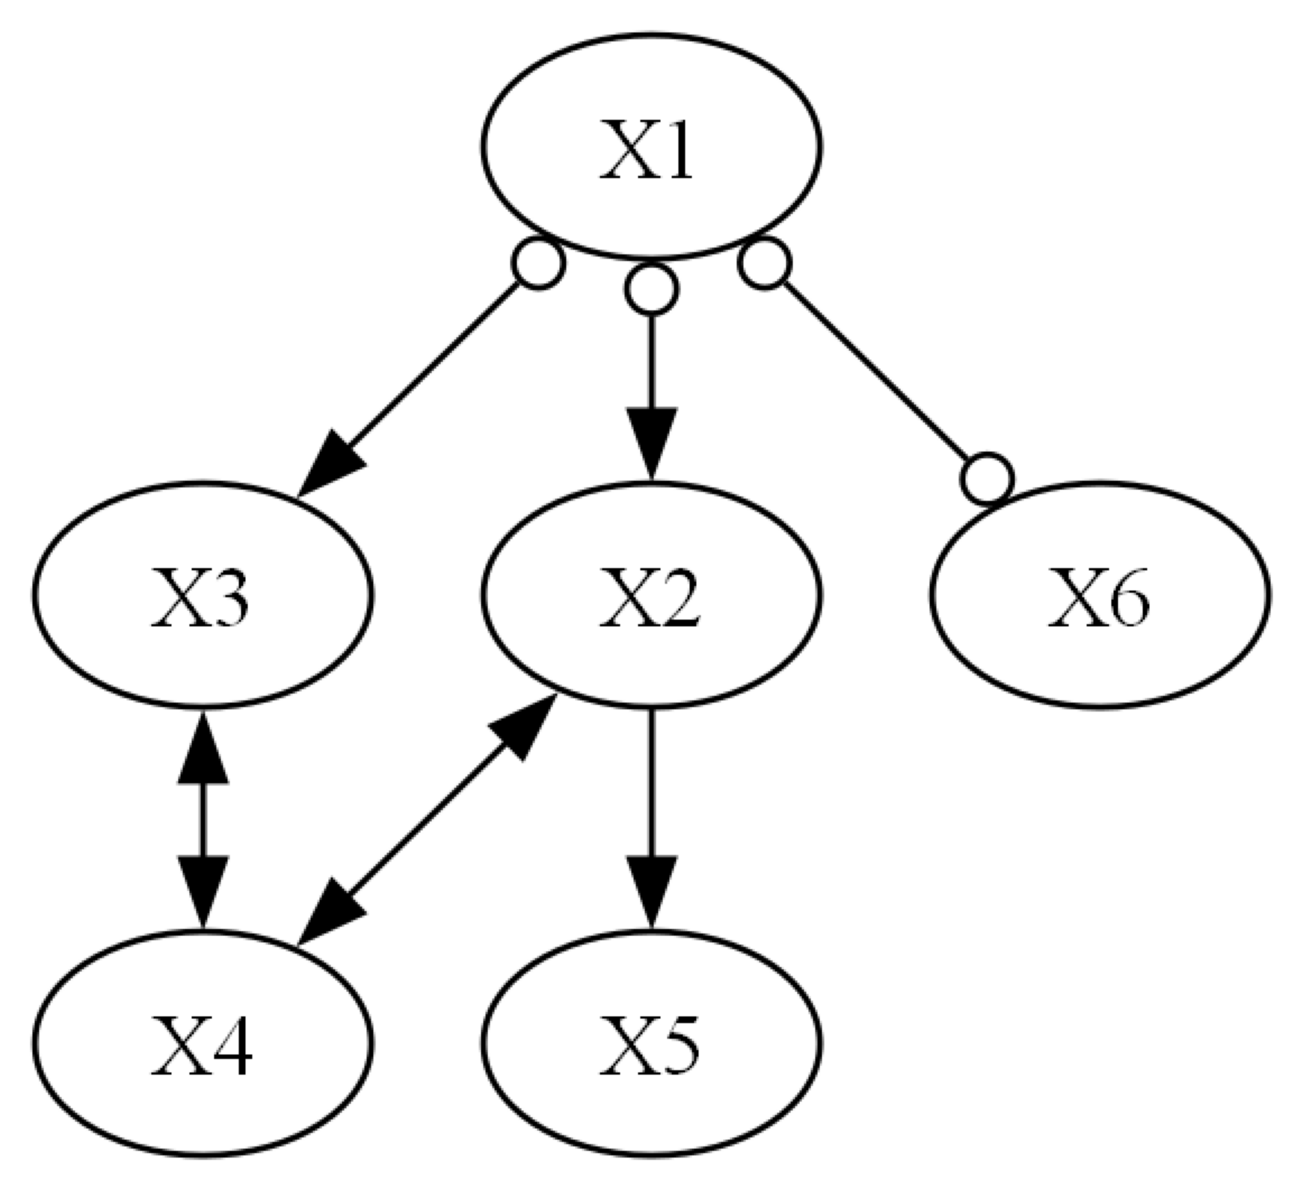

In [80]:
base_cg.draw_pydot_graph()

In [81]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 5, 'false_positive': 1, 'false_negative': 1, 'true_negative': 8, 'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1_score': 0.8333333333333334}
Arrow confusion:  {'true_positive': 5.0, 'false_positive': 2.0, 'false_negative': 4.0, 'true_negative': 25.0, 'precision': 0.7142857142857143, 'recall': 0.5555555555555556, 'f1_score': 0.6250000000000001, 'true_positive_ce': 5.0, 'false_positive_ce': 0.0, 'false_negative_ce': 2.0, 'true_negative_ce': 29.0, 'precision_ce': 1.0, 'recall_ce': 0.7142857142857143, 'f1_score_ce': 0.8333333333333333}
SHD:  4
SID:  {'sid_lower': None}


In [82]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 5, 'false_positive': 1, 'false_negative': 1, 'true_negative': 8, 'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1_score': 0.8333333333333334}
Arrow confusion:  {'true_positive': 6.0, 'false_positive': 2.0, 'false_negative': 3.0, 'true_negative': 25.0, 'precision': 0.75, 'recall': 0.6666666666666666, 'f1_score': 0.7058823529411765, 'true_positive_ce': 6.0, 'false_positive_ce': 0.0, 'false_negative_ce': 1.0, 'true_negative_ce': 29.0, 'precision_ce': 1.0, 'recall_ce': 0.8571428571428571, 'f1_score_ce': 0.923076923076923}
SHD:  5
SID:  {'sid_lower': None}


I don't know why SHD is 5 for C-FCI and 4 for FCI, even though the skeletons are the same. It must be a bug in causallearn when calculating the SHD due to the different Endpoint.VALUES. 